<a href="https://colab.research.google.com/github/SigridKnag/Master-Thesis-2023/blob/main/MasterThesis_2023_SK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and install packages

In [ ]:
!pip install geemap         # --> Google Earth Engine (GEE)
!pip install geopandas      #--> Geospatial data 
%pip install scikit-learn   #--> Machine learning 
!pip install pyshp           #--> Working with shapefiles
!pip install pycrs          #--> Python GIS package

# Talking with local terminal on your computer
import os

# GEE
import ee
from geemap.conversion import js_snippet_to_py
import geemap
from geemap import ml

# Geospatial data manipulation and analysis tools
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import seaborn as sns
import time


# Machine learning with sci-kit learn
from sklearn import ensemble, metrics
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.datasets import (make_blobs,
                              make_circles,
                              make_moons)
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Statistical tests
import statsmodels.api as sm
from scipy.stats import shapiro 
from math import sqrt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Check which prorcessor unit we are using
tf.test.gpu_device_name()

''

In [ ]:
# Initialize access to GEE
Map = geemap.Map()

# 0) Follow external link 
# 1) Choose project name
# 2) "Generate token"
# 3) Choose account
# 4) Give access (check of both boxes)
# 5) Copy authorization code
# 6) Add authorization code below

In [ ]:
# Metadata on hardware, software etc. 
geemap.Report()

--------------------------------------------------------------------------------
  Date: Tue Mar 28 10:28:07 2023 UTC

                OS : Linux
            CPU(s) : 2
           Machine : x86_64
      Architecture : 64bit
               RAM : 12.7 GiB
       Environment : IPython

  Python 3.9.16 (main, Dec  7 2022, 01:11:51)  [GCC 9.4.0]

            geemap : 0.20.4
                ee : 0.1.346
        ipyleaflet : 0.17.2
            folium : 0.14.0
        jupyterlab : Module not found
          notebook : 6.3.0
         ipyevents : 2.0.1
         geopandas : 0.12.2
--------------------------------------------------------------------------------

# Functions
- Deglint
- Remove duplicates

In [ ]:

# Deglint function
def deglint(img):
  '''
  Sun-glint correction of image
  '''
  # Blue (B2) and NIR (B8) 
  # linearfitB gets linear relationship (slope) and offset between the Blue and NIR bands
  linearfitB = img.select(['B8','B2']).reduceRegion(
    **{
    'reducer': ee.Reducer.linearFit(),  
    'geometry': glint,
    'scale':10,
    'maxPixels':1e9
    }) 

  # Green (B3) and NIR (B8)
  # linearfitG gets linear relationship (slope) and offset between the Green and NIR bands  
  linearfitG = img.select(['B8','B3']).reduceRegion(
     **{
      'reducer': ee.Reducer.linearFit(),
      'geometry': glint,
      'scale':10,
      'maxPixels':1e9
      })  
  # Red (B4) and NIR
  # linearfitR gets linear relationship (slope) and offset between the Red and NIR bands
  linearfitR = img.select(['B8','B4']).reduceRegion(
    **{
      'reducer': ee.Reducer.linearFit(),
      'geometry': glint,
      'scale':10,
      'maxPixels':1e9
      })
  
  
  slopeImage = ee.Dictionary(            # Collects the slopes in a dictionary 
  {
      'Blue': linearfitB.get('scale'),
      'Green': linearfitG.get('scale'),
      'Red': linearfitR.get('scale')
      }).toImage()                        # Converts dicitonary to image
      
  # Define minimum NIR value.
  # Source code: https://gis.stackexchange.com/questions/331890/wgs84-projection-is-invalid-for-aggregations . Accessed 02.03.23 
  minNIR = img.select('B8').reduceRegion(ee.Reducer.min(), glint, 10).toImage()
  # Deglint formula
  return img.select(['B2','B3', 'B4']).subtract(slopeImage.multiply(img.select('B8').subtract(minNIR)))


# Function to remove duplicates from a dataset
  def remove_duplicates(data):

  # Get the class column name
  label = data.columns[-1]

  # remove all duplicates
  data_ndup = data.drop_duplicates()

  # Check for imbalance in dataset
  minimum = min(data_ndup[label].value_counts())

  # Correct for imbalance in dataset
  # source code: https://stackoverflow.com/questions/52935324/make-dataframe-balanced-with-respect-to-a-specific-column. Accessed 13.03.23
  data_ndup = (data_ndup.groupby(label, as_index=False)
        .apply(lambda x: x.sample(n=minimum))
        .reset_index(drop=True))
  return data_ndup


'\n# Remove duplicates function\n  def remove_duplicates(data):\n  # Get the class column name\n  label = data.columns[-1]\n\n  # remove all duplicates\n  data_ndup = data.drop_duplicates()\n  # Check for imbalance in dataset\n  minimum = min(data_ndup[label].value_counts())\n\n  # Correct for imbalance in dataset\n  # source code: https://stackoverflow.com/questions/52935324/make-dataframe-balanced-with-respect-to-a-specific-column. Accessed 13.03.23\n  data_ndup = (data_ndup.groupby(label, as_index=False)\n        .apply(lambda x: x.sample(n=minimum))\n        .reset_index(drop=True))\n  return data_ndup\n  '

# Collecting training data

In [ ]:
# Source code: https://developers.google.com/earth-engine/guides/ic_info. Accessed: 16.02.2023
point = ee.Geometry.Point([-69.740859, 43.544235]) # Center around a specified point

# Criteria for maximum cloudiness
MAX_CLOUD_PROBABILITY = 5
CLOUD_THRES = 5
######################################################################################################################
######################################################################################################################
# Get the least cloudy image
image_train = (
    ee.ImageCollection('COPERNICUS/S2_SR')         # Dataset from GEE
    .filterBounds(point)                           # Filter satellite-images around our region of interest (ROI)
    .filterDate('2019-06-02','2019-10-01')         # Filter time
    .sort('CLOUDY_PIXEL_PERCENTAGE')               # fiter for cloud percentage
    .first()                                       # Take the image with least cloud coverage
    .select('B[2-4]','B[8]')                       # Select bands B2, B3, B4, and B8 as features
)
######################################################################################################################
######################################################################################################################
# Create a collection of images over a time-periode for training data
s2_coll_train = (ee.ImageCollection('COPERNICUS/S2_SR')
            .filterBounds(point)  # Filter satellite-images around our region of interest (ROI)
            .filterDate('2019-06-02','2019-10-01')
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_THRES))
    )

######################################################################################################################
######################################################################################################################

# Create a composite training image using min-value
s2_composite_min=s2_coll_train.select(['B[2-4]','B[8]']).min()
# Create a composite training image using the median-value
s2_composite_median = s2_coll_train.select(['B[2-4]','B[8]']).median()

# Number of images fulfilling the cloud-coverage critera that will be used to make a composite image  
print('Number of Sentinel 2 images in creating the training composite with:', s2_coll_train.size().getInfo())
 # Print date and cloud percentage (in decimal)
print('The least cloudy image was taken (YYYY-MM-DD):', ee.Date(image_train.get('system:time_start')).format('YYYY-MM-dd').getInfo())
cloud_perc = image_train.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()*100
print(f'Cloud percentage: {cloud_perc:,.2f}% of the least cloudy image')
print('features available:', s2_composite_min.bandNames().getInfo())

Number of Sentinel 2 images in creating the training composite with: 4
The least cloudy image was taken (YYYY-MM-DD): 2019-07-19
Cloud percentage: 3.15% of the least cloudy image
features available: ['B2', 'B3', 'B4', 'B8']


In [ ]:
# Instantiate a new map
Map = geemap.Map()
Map.set_center(-69.740859, 43.544235, zoom=10)

# Visually inspect the image and composite iamges created  
vis_params = {"bands": [ 'B2', 'B3', 'B4'], "min": 0, "max": 1500, "gamma": 3.5}
Map.addLayer(image_train, vis_params, 'Sent-2 image')
Map.addLayer(s2_composite_median, vis_params, 'Sent-2 median')
Map.addLayer(s2_composite_min, vis_params, 'Sent-2 min')
# Use toolbar on the left side, e.g., " Draw a rectangle" over a sight 
# to extract NIR values (min and random) from two pixels. 
# Areas of deep waters are recommended.
Map
# Draw a rectangle in an area of deep water! 

Map(center=[43.544235, -69.740859], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [ ]:
##Sun-glint correction
# Adaptation from https://www.youtube.com/watch?v=_V0X1LdSta4. Accessed 10.02.2023.

Map.draw_features                                # Collects the drawn rectangle(s)
glint = ee.FeatureCollection(Map.draw_features)  # Stores the rectangle(s) geometry to extract NIR-values from

def deglint(img):
  '''
  Sun-glint correction of image
  '''
  # Blue (B2) and NIR (B8) 
  # linearfitB gets linear relationship (slope) and offset between the Blue and NIR bands
  linearfitB = img.select(['B8','B2']).reduceRegion(
    **{
    'reducer': ee.Reducer.linearFit(),  
    'geometry': glint,
    'scale':10,
    'maxPixels':1e9
    }) 

  # Green (B3) and NIR (B8)
  # linearfitG gets linear relationship (slope) and offset between the Green and NIR bands  
  linearfitG = img.select(['B8','B3']).reduceRegion(
     **{
      'reducer': ee.Reducer.linearFit(),
      'geometry': glint,
      'scale':10,
      'maxPixels':1e9
      })  
  # Red and NIR
  # linearfitR gets linear relationship (slope) and offset between the Red and NIR bands
  linearfitR = img.select(['B8','B4']).reduceRegion(
    **{
      'reducer': ee.Reducer.linearFit(),
      'geometry': glint,
      'scale':10,
      'maxPixels':1e9
      })
  
  
  slopeImage = ee.Dictionary(            # Collects the slopes in a dictionary 
  {
      'Blue': linearfitB.get('scale'),
      'Green': linearfitG.get('scale'),
      'Red': linearfitR.get('scale')
      }).toImage()                        # Converts dicitonary to image
      
  # Define minimum NIR value. 
  # Source code: https://gis.stackexchange.com/questions/331890/wgs84-projection-is-invalid-for-aggregations
  minNIR = img.select('B8').reduceRegion(ee.Reducer.min(), glint, 10).toImage()
  # Deglint formula
  return img.select(['B2','B3', 'B4']).subtract(slopeImage.multiply(img.select('B8').subtract(minNIR)))

# Deglinted image
S2_deglint = deglint(s2_composite_min) 

mask = S2_deglint.gt(0)                              # Using threshold 0 to distinguish land from ocean.
s2_deglint_masked = S2_deglint.updateMask(mask)      # Ocean mask 

NIR_thres = 500
b8 =s2_composite_min.select('B8')

# Source code: https://code.earthengine.google.com/?accept_repo=users%2Fstcarp%2FCME_MappingWorkshop. Accessed: 23.03.23
threshold = b8.where(b8.gt(NIR_thres),1).where(b8.lt(NIR_thres),0)

# Source code: https://www.youtube.com/watch?v=qO3Te5pfOHc. Accesssed: 23.03.23
S2_masked = threshold.updateMask(threshold)    # Land mask

# Display layers
vis_params_deglint = {"bands": [ 'B2', 'B3','B4'], "min": 0, "max": 1500, 'gamma':1.5}  # Visible parameters 

Map.addLayer(S2_deglint, vis_params_deglint, 'sun-glint corrected Sent-2')              # Deglinter image  
Map.addLayer(s2_deglint_masked, vis_params_deglint, 'masked Sent-2 deglinted image')    # Ocean layer without land
Map.addLayer(S2_masked, {'palette': ['black']} , 'S2 Land Mask')                        # Land mask with black color
Map

Map(bottom=96179.26121626484, center=[43.445679561025706, -69.44159462344241], controls=(WidgetControl(options…

In [ ]:
# Calculating NDVI
nir = s2_composite_min.select('B8')
red = s2_composite_min.select('B4')
ndvi_image = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

# Add NIR-band to deglinted image
s2_deglint_masked = s2_deglint_masked.addBands(nir)

# Add NDVI to RGB-image and deglinted image
s2_deglint_masked = s2_deglint_masked.addBands(ndvi_image)
Map

Map(bottom=96179.0, center=[43.445679561025706, -69.44159462344241], controls=(WidgetControl(options=['positio…

In [ ]:
# Store region of interst (training) locally for reproducability 
# roi_train = ee.FeatureCollection(Map.draw_last_feature)
#geemap.ee_to_shp(roi_train, filename='/content/roi_train.shp') 

shp_path_roi_train = '/content/roi_train.shp'
roi_train = geemap.shp_to_ee(shp_path_roi_train)

#Citations:
# Amante, C. and B. W. Eakins, ETOPO1 1 Arc-Minute Global Relief Model: Procedures, Data Sources and Analysis. 
# NOAA Technical Memorandum NESDIS NGDC-24, 19 pp, March 2009.

# Import elevation dataset from GEE
dataset = ee.Image('NOAA/NGDC/ETOPO1')
bathymetry_clipped = dataset.clip(roi_train)

# Extract band 'bedrock' and rename it bathymetry for convenience
bathymetry = bathymetry_clipped.select('bedrock').rename('bathymetry')

# Add bathymetry band to deglinted and raw image
s2_deglint_masked = s2_deglint_masked.addBands(bathymetry)

# Add NDVI-image to map
ndviParams = {min: -1, max: 1, 'palette': ['blue', 'white', 'green']}
Map.addLayer(ndvi_image, ndviParams, 'NDVI image')
Map.addLayer(roi_train, {}, 'training site')

# Add bathymetry data on the map
bathymetryVis = {
  'min': -7000.0,
  'max': 3000.0,
  'palette': ['011de2', 'afafaf', '3603ff', 'fff477', 'b42109'],
}
Map.addLayer(bathymetry, bathymetryVis, 'bathymetry')
Map

Map(bottom=96179.0, center=[43.445679561025706, -69.44159462344241], controls=(WidgetControl(options=['positio…

In [ ]:
# Add ground truth data geometry of seagrass, seaweed, and water
shp_path_SW = '/content/Coastal_Marine_Geology.shp'
seaweed_shp = geemap.shp_to_ee(shp_path_SW)

shp_path_SG = '/content/MaineDEP_-_Eelgrass_2018_(Casco_Bay_Only).shp'
seagrass_shp = geemap.shp_to_ee(shp_path_SG)

# Drew rectangles to represent water, than downloaded them locally
# geemap.ee_to_shp(water, filename='/content/water.shp')
shp_path_water = '/content/water.shp'
water_shp = geemap.shp_to_ee(shp_path_water)

# increase sample size of seaweed
sample_sw = s2_deglint_masked.sample(**{
  'region': seaweed_shp.geometry(),
  'numPixels':5000,  # Collect only a 100 datapoints from the geometries to as there as so few polygons of seagrass in the area
  'geometries': True,
  'seed' :3,
  'scale': 10,   # Set to 10 as our resolution is 10-meters
})

sample_sg = s2_deglint_masked.sample(**{
  'region': seagrass_shp.geometry(),
  'numPixels':5000,   
  'geometries': True,
  'seed' :3,
  'scale': 10,
})

sample_water = s2_deglint_masked.sample(**{
  'region': water_shp.geometry(),
  'numPixels':5000,
  'geometries': True,
  'seed' :3,
  'scale': 10,
})

# Convert samples from ee-objects to geodataframes
gdf_sw = geemap.ee_to_geopandas(sample_sw)
gdf_sg = geemap.ee_to_geopandas(sample_sg)
gdf_water = geemap.ee_to_geopandas(sample_water)

# Get number of samples fetched for each class
length_sg = len(gdf_sg)
length_sw = len(gdf_sw)
length_water = len(gdf_water)
print(f'We have: \n {length_sg} samples from the seagrass polygons \n {length_sw} samples from the seaweed polygons \n {length_water} samples from the water polygons ')

 # Crete Class column 'Cover'
gdf_water['Cover'] =  int(1) # class water
gdf_sw['Cover'] =  int(2)    # class seaweed
gdf_sg['Cover'] =  int(3)    # class seagrass


# Merge the three dataframes and create a single dataset
# Source code: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html. Accessed 08.02.23
frames = [gdf_water, gdf_sw, gdf_sg]

data = pd.concat(frames, ignore_index=True)
print(len(data))

We have: 
 4874 samples from the seagrass polygons 
 939 samples from the seaweed polygons 
 4992 samples from the water polygons 
10805


# Visually compare the sample points to the ground truth polygons. 

In [ ]:
Map = geemap.Map()
Map.set_center(-69.740859, 43.544235, zoom=10)

vis_params = {"bands": [ 'B2', 'B3', 'B4'], "min": 0, "max": 1500, "gamma": 1.5}
Map.addLayer(image_train, vis_params, 'Sent-2 image')
Map.addLayer(s2_composite_min, vis_params, 'Sent-2 min')

vis_params_deglint = {"bands": [ 'B2', 'B3','B4'], "min": 0, "max": 1500, 'gamma':1.5}

Map.addLayer(S2_deglint, vis_params_deglint, 'sun-glint corrected Sent-2')
Map.addLayer(s2_deglint_masked, vis_params_deglint, 'masked Sent-2 deglinted image')

vis_params_sw = {'color':'#7b3e00'}
vis_params_sg = {'color':'1c5f2c'} 
vis_params_water = {'color':'#0d98ba'}  

# Ground truth polygons 
Map.addLayer(seagrass_shp, vis_params_sg, 'seagrass')
Map.addLayer(seaweed_shp, vis_params_sw, 'seaweed')
Map.addLayer(water_shp, vis_params_water, 'water')

# Sample points
Map.addLayer(sample_sg, vis_params_sg, 'seagrass samples')
Map.addLayer(sample_sw, vis_params_sw, 'seaweed samples')
Map.addLayer(sample_water, vis_params_water, 'water samples')
Map

# OBIA-method at the training site

In [ ]:
# Select seed-pixels for clustering, spaced at least 36 pixels apart. Clipped to region of interest.  
seeds = ee.Algorithms.Image.Segmentation.seedGrid(36).clip(roi_train)

# Run SNIC --> create super-pixels
snic = ee.Algorithms.Image.Segmentation.SNIC(**{
  'image': s2_deglint_masked,                     # Image to create superpixels                    
  'size': 32,                                     # Spacing between each seed in pixels. Each seed are 32 pixels away from each other       
  'compactness': 5,                               # How compact the super-pixels should be. Larger values creates squares, small more organic patterns
  'connectivity': 8,                              # Number of pixels that can be connected to one pixel. 4 means the pixels around one that shares a side, 8 means also those pixels who touches the corners of a pixel. 
  'neighborhoodSize':256,                         # 
  'seeds': seeds                                  # Square grid of seeds. Each seed with a spacing of 36 pixels inbetween them. 
})

# Outputs average values for the super-pixels 
snic.bandNames().getInfo()

['clusters',
 'B2_mean',
 'B3_mean',
 'B4_mean',
 'B8_mean',
 'NDVI_mean',
 'bathymetry_mean']

In [ ]:
#Display the clusters.
Map.addLayer(snic.randomVisualizer(), None, 'Clusters')
# Display the RGB cluster means.
visParams = {
  'bands': ['B4_mean', 'B3_mean', 'B2_mean'],
  'min': 0,
  'max': 255
}

vis_params_sw = {'color':'#7b3e00'}
vis_params_sg = {'color':'1c5f2c'} 

Map.addLayer(snic, visParams, 'RGB cluster means')
#Map.addLayer(S2_masked, {'palette': ['black']} , 'S2 Land Mask')
#Map.addLayer(seagrass_shp, vis_params_sg, 'seagrass')
#Map.addLayer(seaweed_shp, vis_params_sw, 'seaweed')
Map

Map(bottom=191374.0, center=[43.78611572393797, -69.98861488008205], controls=(WidgetControl(options=['positio…

In [ ]:
'''
# In order to try to still the image (avoid the super-pixels to change with scale), code commented out here is used. Did not work...
# source code: https://gis.stackexchange.com/questions/333413/is-google-earth-engine-snic-segmentation-algorithm-inconsistent. Accessed 10.02.23
snic.reproject(**{
  'crs': 'EPSG:4326',
  'scale': 10
})

# Source code: https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic. 10.02.23
# Lock map zoom to maintain the desired scale of the segmentation computation.
'''
# Using super-pixels to get object-based features: 
clusters = snic.select('clusters') 

#Area
area = ee.Image.pixelArea().addBands(clusters).reduceConnectedComponents(ee.Reducer.sum(), 'clusters', 256)
#Map.addLayer(area, {min:50000, max: 500000}, 'Cluster Area', False)

minMax = clusters.reduceNeighborhood(ee.Reducer.minMax(), ee.Kernel.square(1))
perimeterPixels = minMax.select(0).neq(minMax.select(1)).rename('perimeter')

# Perimeter
perimeter = perimeterPixels.addBands(clusters).reduceConnectedComponents(ee.Reducer.sum(), 'clusters', 256);

# Width and Height
sizes = ee.Image.pixelLonLat().addBands(clusters).reduceConnectedComponents(ee.Reducer.minMax(), 'clusters', 256)
width = sizes.select('longitude_max').subtract(sizes.select('longitude_min')).rename('width')
height = sizes.select('latitude_max').subtract(sizes.select('latitude_min')).rename('height')

bands = ['B2_mean', 'B3_mean', 'B4_mean', 'B8_mean','clusters', 'bathymetry_mean','NDVI_mean']

# objectPropertiesImage is now an image containing 11 feautres.  
objectPropertiesImage = ee.Image.cat([
  snic.select(bands).rename(['clusters', 'B2', 'B3', 'B4', 'B8', 'NDVI', 'bathymetry']),
  area,
  perimeter,
  width,
  height
]).float()

# Image with now 11 features and super-pixels
objectPropertiesImage.bandNames().getInfo()


['clusters',
 'B2',
 'B3',
 'B4',
 'B8',
 'NDVI',
 'bathymetry',
 'area',
 'perimeter',
 'width',
 'height']

In [ ]:
# Use functions below if data to get sample data fro training, validaiton and test. 
# To save time, these sets have already been created and stored locally.
# The files used her ecan be found with the rest on git-hub for reproducable results.

# increase sample size of seaweed
sample_sw = objectPropertiesImage.sample(**{
  'region': seaweed_shp,
  'numPixels':5000,  # Collect only a 100 datapoints from the geometries to as there as so few polygons of seagrass in the area
  'geometries': True,
  'seed' :5,
  'scale': 10,   # Set to 10 as our resolution is 10-meters
})

sample_sg = objectPropertiesImage.sample(**{
  'region': seagrass_shp,
  'numPixels':5000,   
  'geometries': True,
  'seed' :5,
  'scale': 10,
})

sample_water = objectPropertiesImage.sample(**{
  'region': water_shp.geometry(),
  'numPixels':5000,
  'geometries': True,
  'seed' :5,
  'scale': 10,
})

# Convert samples from ee-objects to geodataframes
gdf_sw = geemap.ee_to_geopandas(sample_sw)
gdf_sg = geemap.ee_to_geopandas(sample_sg)
gdf_water = geemap.ee_to_geopandas(sample_water)

# Get number of samples fetched for each class
length_sg = len(gdf_sg)
length_sw = len(gdf_sw)
length_water = len(gdf_water)
print(f'We have: \n {length_sg} samples from the seagrass polygons \n {length_sw} samples from the seaweed polygons \n {length_water} samples from the water polygons ')

 # Crete Class column 'Cover'
gdf_water['Cover'] =  int(1) # class water
gdf_sw['Cover'] =  int(2)    # class seaweed
gdf_sg['Cover'] =  int(3)    # class seagrass


# Merge the three dataframes and create a single dataset
# Source code: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html. Accessed 08.02.23
frames = [gdf_water, gdf_sw, gdf_sg]

data = pd.concat(frames, ignore_index=True)
print(len(data))


We have: 
 4999 samples from the seagrass polygons 
 952 samples from the seaweed polygons 
 4815 samples from the water polygons 
10766


In [ ]:
# Visually inspect that the samples are drawn from the training site 
Map = geemap.Map()
Map.set_center(-69.740859, 43.544235, zoom=10)

# Visually inspect the image and composite iamges created  
vis_params = {"bands": [ 'B2', 'B3', 'B4'], "min": 0, "max": 1500, "gamma": 1.5}
Map.addLayer(image_train, vis_params, 'Sent-2 image')

vis_params_sw = {'color':'#7b3e00'}
vis_params_sg = {'color':'1c5f2c'} 
vis_params_water = {'color':'#0d98ba'}  

Map.addLayer(seagrass_shp, vis_params_sg, 'seagrass')
Map.addLayer(seaweed_shp, vis_params_sw, 'seaweed')
Map.addLayer(water_shp, vis_params_water, 'water')

Map.addLayer(sample_sg, vis_params_sg, 'seagrass samples')
Map.addLayer(sample_sw, vis_params_sw, 'seaweed samples')
Map.addLayer(sample_water, vis_params_water, 'water samples')
Map

# Storing data locally

In [ ]:
# Store the training data locally for reproducability and faster 
# data = data11_ndup
# All data: 
# 1) data.head()               # Check how the data looks 
# 2) data.describe()
# 2) data.isnull().sum().sum() # Check for null-values 
# 3) data.columns              # Found mix-up mistake of columns
# 4) data = data.drop(['geometry'], axis=1) # Remove duplicates created 
# 5) data.head()                # Verify that our fix worked
# 6) data = data.sample(frac=1) # Randomize the data
# 8) data.to_csv(r'/content/OBIA_train11.csv', index=False) 

# Collecting test-data


In [ ]:
# Source code: https://developers.google.com/earth-engine/guides/ic_info. Accessed: 16.02.2023
point_test = ee.Geometry.Point([-70.269, 43.680]) # Center around a specified point

# Criteria for maximum cloudiness
MAX_CLOUD_PROBABILITY = 5
CLOUD_THRES = 5

######################################################################################################################
######################################################################################################################
# Get the least cloudy image
image_test = (
    ee.ImageCollection('COPERNICUS/S2_SR')         # Dataset from GEE
    .filterBounds(point_test)                           # Filter satellite-images around our region of interest (ROI)
    .filterDate('2021-06-02','2021-11-01')         # Filter time
    .sort('CLOUDY_PIXEL_PERCENTAGE')               # fiter for cloud percentage
    .first()                                       # Take the image with least cloud coverage
    .select('B[2-4]','B[8]')                       # Select bands B2, B3, B4, and B8 as features
)
######################################################################################################################
######################################################################################################################
# Create a collection of images over a time-periode for training data
s2_coll_test = (ee.ImageCollection('COPERNICUS/S2_SR')
            .filterBounds(point_test)                 # Filter satellite-images around our region of interest (ROI)
            .filterDate('2021-06-02','2021-10-01')
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_THRES))
    )

# Create a composite training image using min-value
s2_composite_min=s2_coll_test.select(['B[2-4]','B[8]']).min()
# Create a composite training image using the median-value
s2_composite_median = s2_coll_test.select(['B[2-4]','B[8]']).median()

# Number of images fulfilling the cloud-coverage critera that will be used to make a composite image  
print('Number of Sentinel 2 images in creating the training composite with:', s2_coll_test.size().getInfo())
 # Print date and cloud percentage (in decimal)
print('The least cloudy image was taken (YYYY-MM-DD):', ee.Date(image_test.get('system:time_start')).format('YYYY-MM-dd').getInfo())
cloud_perc = image_test.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()*100
print(f'Cloud percentage: {cloud_perc:,.2f}% of the least cloudy image')
print('features available:', s2_composite_min.bandNames().getInfo())

Number of Sentinel 2 images in creating the training composite with: 5
The least cloudy image was taken (YYYY-MM-DD): 2021-10-24
Cloud percentage: 30.48% of the least cloudy image
features available: ['B2', 'B3', 'B4', 'B8']


In [ ]:
# Instantiate a new map
Map = geemap.Map()
Map.set_center(-69.740859, 43.544235, zoom=10)

# Visually inspect the image and composite iamges created  
vis_params = {"bands": [ 'B2', 'B3', 'B4'], "min": 0, "max": 1500, "gamma": 1.5}
Map.addLayer(image_test, vis_params, 'Sent-2 image test')
Map.addLayer(s2_composite_median, vis_params, 'Sent-2 median')
Map.addLayer(s2_composite_min, vis_params, 'Sent-2 min')
# Use toolbar on the left side, e.g., " Draw a rectangle" over a sight 
# to extract NIR values (min and random) from two pixels. 
# Areas of deep waters are recommended.
Map
# Draw a rectangle in an area of deep water! 

Map(center=[43.544235, -69.740859], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [ ]:
# Store glint_test locally for reproducability 
#Map.draw_features                                # Collects the drawn rectangle(s)
#glint = ee.FeatureCollection(Map.draw_features)  # Stores the rectangle(s) geometry to extract NIR-values from

#geemap.ee_to_shp(glint, filename='/content/glint_test.shp') 

In [ ]:
# Apply deglint function
path_glint_test = '/content/glint_test.shp'
glint = geemap.shp_to_ee(path_glint_test)

S2_deglint = deglint(s2_composite_min) 

mask = S2_deglint.gt(0)
s2_deglint_masked = S2_deglint.updateMask(mask)


NIR_thres = 500
b8 =s2_composite_min.select('B8')

# Source code: https://code.earthengine.google.com/?accept_repo=users%2Fstcarp%2FCME_MappingWorkshop. Accessed: 23.03.23
threshold = b8.where(b8.gt(NIR_thres),1).where(b8.lt(NIR_thres),0)
#Map.addLayer(landmask, {'bands': ['B8'], 'gamma': 1, 'max': 1, 'opacity': 1},'S2 Land Mask')

# Source code: https://www.youtube.com/watch?v=qO3Te5pfOHc. Accesssed: 23.03.23
# Land mask
S2_masked = threshold.updateMask(threshold)
vis_params_deglint = {"bands": [ 'B2', 'B3','B4'], "min": 0, "max": 1500, 'gamma':1.5}

Map.addLayer(s2_deglint_masked, vis_params_deglint, 'masked Sent-2 deglinted image')
Map.addLayer(S2_masked, {'palette': ['black']} , 'S2 Land Mask')


# Show deglinted image in map
vis_params_deglint = {"bands": [ 'B2', 'B3','B4'], "min": 0, "max": 1500, 'gamma':1.5}

Map.addLayer(S2_deglint, vis_params_deglint, 'sun-glint corrected Sent-2')
Map

Map(bottom=191972.0, center=[43.48878530962692, -70.57723632329628], controls=(WidgetControl(options=['positio…

In [ ]:
# Add feature: NDVI 

# Calculating NDVI
nir = s2_composite_min.select('B8')
red = s2_composite_min.select('B4')
ndvi_image = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

# Add NIR-band to deglinted image
s2_deglint_masked = s2_deglint_masked.addBands(nir)

# Add NDVI to RGB-image and deglinted image
s2_deglint_masked = s2_deglint_masked.addBands(ndvi_image)

# sent2019 = ee.Image('COPERNICUS/S2/20190719T153601_20190719T153707_T19TDJ')
# Visualize the added features to show that they are actually added 

In [ ]:
# Store region of interst (test) locally for reproducability 
#roi_test = ee.FeatureCollection(Map.draw_last_feature)
#geemap.ee_to_shp(roi_test, filename='/content/roi_test.shp') 


Generating URL ...
Please wait ...
Data downloaded to /content/roi_test.shp


In [ ]:
# Add ground truth data geometry of seagrass, seaweed, and water
# Must upload to google colabs for each new runtime...
shp_path_SW = '/content/Coastal_Marine_Geology.shp'
seaweed_shp = geemap.shp_to_ee(shp_path_SW)

shp_path_SG = '/content/MaineDEP_Seagrass_2021_(South_Coast_-_Elliot_to_Cape_Elizabeth).shp'
seagrass_shp = geemap.shp_to_ee(shp_path_SG)

# Drew rectangles to represent water, than downloaded them locally
# geemap.ee_to_shp(water, filename='/content/water.shp')
shp_path_water_test = '/content/water_test.shp'
water_test_shp = geemap.shp_to_ee(shp_path_water_test)

shp_path_roi_test = '/content/roi_test.shp'
roi_test = geemap.shp_to_ee(shp_path_roi_test)

In [ ]:
#Citations:
# Amante, C. and B. W. Eakins, ETOPO1 1 Arc-Minute Global Relief Model: Procedures, Data Sources and Analysis. 
# NOAA Technical Memorandum NESDIS NGDC-24, 19 pp, March 2009.

# Import elevation dataset from GEE
dataset = ee.Image('NOAA/NGDC/ETOPO1')
bathymetry_clipped = dataset.clip(roi_test)
# Extract band 'bedrock' and rename it bathymetry for convenience
bathymetry = bathymetry_clipped.select('bedrock').rename('bathymetry')
# Add bathymetry band to deglinted and raw image
s2_deglint_masked = s2_deglint_masked.addBands(bathymetry)

# Add NDVI-image to map
ndviParams = {min: -1, max: 1, 'palette': ['blue', 'white', 'green']}
Map.addLayer(ndvi_image, ndviParams, 'NDVI image')

# Add bathymetry data on the map
bathymetryVis = {
  'min': -7000.0,
  'max': 3000.0,
  'palette': ['011de2', 'afafaf', '3603ff', 'fff477', 'b42109'],
}
Map.addLayer(bathymetry, bathymetryVis, 'bathymetry')


Map

Map(bottom=191972.0, center=[43.48878530962692, -70.57723632329628], controls=(WidgetControl(options=['positio…

In [ ]:
s2_deglint_masked.bandNames()

# OBIA test


In [ ]:
# Select seed-pixels for clustering, spaced at least 36 pixels apart. Clipped to region of interest.  
seeds = ee.Algorithms.Image.Segmentation.seedGrid(36).clip(roi_test)

# Run SNIC
snic = ee.Algorithms.Image.Segmentation.SNIC(**{
  'image': s2_deglint_masked,                               
  'size': 32,                                      # 
  'compactness': 5,
  'connectivity': 8,
  'neighborhoodSize':256,
  'seeds': seeds
})


In [ ]:
snic.bandNames().getInfo()

['clusters',
 'B2_mean',
 'B3_mean',
 'B4_mean',
 'bathymetry_mean',
 'B8_mean',
 'NDVI_mean']

In [ ]:
'''
# Source code: https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic. 10.02.23
# Lock map zoom to maintain the desired scale of the segmentation computation.
# Source: https://code.earthengine.google.com/ 03.04.2023
#Display the clusters.
Map.addLayer(snic.randomVisualizer(), None, 'Clusters')
# Display the RGB cluster means.
visParams = {
  'bands': ['R', 'G', 'B'],
  'min': 0,
  'max': 255
}
Map.addLayer(snic, visParams, 'RGB cluster means')
'''
# Compute per-cluster stdDev.
clusters = snic.select('clusters')    # image.addBands(clusters) or S2_deglint.addBands(clusters)
#stdDev = S2_deglint.addBands(clusters).reduceConnectedComponents(ee.Reducer.stdDev(), 'clusters', 256)
#Map.addLayer(stdDev, {min:0, max:0.1}, 'StdDev', False)

#Area
area = ee.Image.pixelArea().addBands(clusters).reduceConnectedComponents(ee.Reducer.sum(), 'clusters', 256)
#Map.addLayer(area, {min:50000, max: 500000}, 'Cluster Area', False)

minMax = clusters.reduceNeighborhood(ee.Reducer.minMax(), ee.Kernel.square(1))
perimeterPixels = minMax.select(0).neq(minMax.select(1)).rename('perimeter')
#Map.addLayer(perimeterPixels, {min: 0, max: 1}, 'perimeterPixels')

# Perimeter # I wonder if I set all scale = 10 in the reducers if they not need reprojection later
perimeter = perimeterPixels.addBands(clusters).reduceConnectedComponents(ee.Reducer.sum(), 'clusters', 256);
#Map.addLayer(perimeter, {min: 100, max: 400}, 'Perimeter size', False);

# Width and Height
sizes = ee.Image.pixelLonLat().addBands(clusters).reduceConnectedComponents(ee.Reducer.minMax(), 'clusters', 256)
width = sizes.select('longitude_max').subtract(sizes.select('longitude_min')).rename('width')
height = sizes.select('latitude_max').subtract(sizes.select('latitude_min')).rename('height')
#Map.addLayer(width, {min:0, max:0.02}, 'Cluster width', False)
#Map.addLayer(height, {min:0, max:0.02}, 'Cluster height', False)


In [ ]:
bands = ['clusters',
 'B2_mean',
 'B3_mean',
 'B4_mean',
 'B8_mean',
 'NDVI_mean',
 'bathymetry_mean']

# objectPropertiesImage is now an image containing 11 feautres.  
objectPropertiesImage = ee.Image.cat([
  snic.select(bands).rename(['clusters', 'B2', 'B3', 'B4', 'B8', 'NDVI', 'bathymetry',]),
  area,
  perimeter,
  width,
  height
]).float()

In [ ]:
objectPropertiesImage.bandNames().getInfo()

['clusters',
 'B2',
 'B3',
 'B4',
 'B8',
 'NDVI',
 'bathymetry',
 'area',
 'perimeter',
 'width',
 'height']

In [ ]:
# Use functions below if data to get sample data fro training, validaiton and test. 
# To save time, these sets have already been created and stored locally.
# The files used her ecan be found with the rest on git-hub for reproducable results.

# increase sample size of seaweed
sample_sw = objectPropertiesImage.sample(**{
  'region': seaweed_shp,
  'numPixels':5000,  # First test set: 110, second: 
  'geometries': True,
  'seed' :3,
  'scale': 10,   # Set to 10 as our resolution is 10-meters
})

sample_sg = objectPropertiesImage.sample(**{
  'region': seagrass_shp,
  'numPixels':5000,      # First test set: 300000
  'geometries': True,
  'seed' :42,
  'scale': 10,
})

sample_water = objectPropertiesImage.sample(**{
  'region': water_test_shp.geometry(),
  'numPixels':5000,       # First test set: 300000
  'geometries': True,
  'seed' :3,
  'scale': 10,
})

# Convert samples from ee-objects to geodataframes
gdf_sw = geemap.ee_to_geopandas(sample_sw)
gdf_sg = geemap.ee_to_geopandas(sample_sg)
gdf_water = geemap.ee_to_geopandas(sample_water)

# Get number of samples fetched for each class
length_sg = len(gdf_sg)
length_sw = len(gdf_sw)
length_water = len(gdf_water)
print(f'We have: \n {length_sg} samples from the seagrass polygons \n {length_sw} samples from the seaweed polygons \n {length_water} samples from the water polygons ')

 # Crete Class column 'Cover'
gdf_water['Cover'] =  int(1) # class water
gdf_sw['Cover'] =  int(2)    # class seaweed
gdf_sg['Cover'] =  int(3)    # class seagrass


# Merge the three dataframes and create a single dataset
# Source code: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html. Accessed 08.02.23
frames = [gdf_water, gdf_sw, gdf_sg]

data_test_OBIA = pd.concat(frames, ignore_index=True)
print(len(data_test_OBIA))

We have: 
 3299 samples from the seagrass polygons 
 1404 samples from the seaweed polygons 
 4887 samples from the water polygons 
9590


In [ ]:
data = remove_duplicates(data_test_OBIA)
print(len(data))
print(data['Cover'].value_counts())
data.aggregate(['min','max','mean','median'])

4212
1    1404
2    1404
3    1404
Name: Cover, dtype: int64


B2          B3          B4           B8      NDVI  \
min       4.648089   19.761433    7.502752    14.029513 -0.643138   
max     424.446869  586.466736  314.722870  1680.623169  0.530570   
mean    151.851839  172.319574   65.210750   128.288379 -0.251607   
median  149.610626  160.370346   61.359627    48.347687 -0.247572   

                area  bathymetry      clusters    height    perimeter  \
min     2.910087e+02  -95.000000 -2.143270e+09  0.000090     4.000000   
max     1.337740e+06    9.000000  2.141246e+09  0.022638  3303.000000   
mean    2.524283e+05  -20.576017  1.701418e+07  0.006816   741.305081   
median  1.489008e+05   -8.000000  8.095993e+07  0.005929   551.000000   

           width  Cover  
min     0.000269    1.0  
max     0.022278    3.0  
mean    0.008285    2.0  
median  0.006648    2.0

In [ ]:
data = data11_ndup
print(len(data))
print(data['Cover'].value_counts())
data.aggregate(['min','max','mean','median'])

738
1    246
2    246
3    246
Name: Cover, dtype: int64


B2          B3          B4           B8      NDVI  \
min       3.081182    3.407706    3.775116     0.855829 -0.943325   
max     938.488831  519.432922  497.195038  1134.019531  0.817706   
mean     84.307340   42.195296   34.037155    98.461466 -0.413507   
median   13.884672   11.637926    7.754019     8.075504 -0.451971   

                area  bathymetry      clusters    height    perimeter  \
min     4.326251e+02 -169.000000 -2.136294e+09  0.000090     6.000000   
max     1.508511e+06   18.814028  2.132384e+09  0.020482  3160.000000   
mean    2.217561e+05  -47.036060  2.356907e+07  0.006413   660.636856   
median  1.490917e+05  -13.560373 -4.968477e+07  0.005839   561.000000   

           width  Cover  
min     0.000180    1.0  
max     0.021829    3.0  
mean    0.007403    2.0  
median  0.006692    2.0

In [ ]:
data = remove_duplicates(data_test_OBIA)
print(len(data))
print(data['Cover'].value_counts())
data.aggregate(['min','max','mean','median'])

4164
1    1388
2    1388
3    1388
Name: Cover, dtype: int64


B2          B3          B4           B8      NDVI  bathymetry  \
min      11.445064   72.611548    7.959170     4.000000 -0.887324   -95.00000   
max     414.216802  580.094922  508.628516  1204.000000  0.275949     9.00000   
mean    157.683654  176.932218   65.909692    53.607829 -0.288229   -20.99976   
median  155.026305  166.274654   61.596720    45.000000 -0.283951    -8.00000   

        Cover  
min       1.0  
max       3.0  
mean      2.0  
median    2.0

<Axes: >

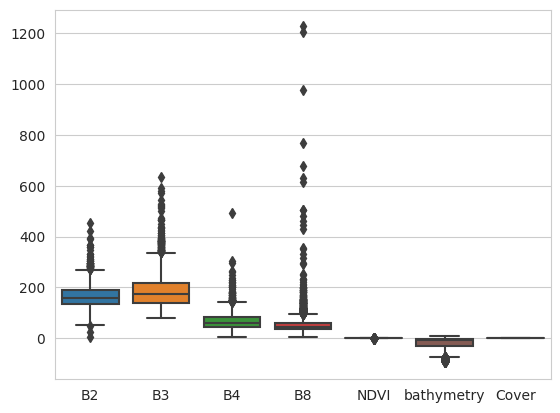

In [ ]:
sns.boxplot(data)
# Why these values: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED?hl=en. Accessed 03.04.2023

<Axes: >

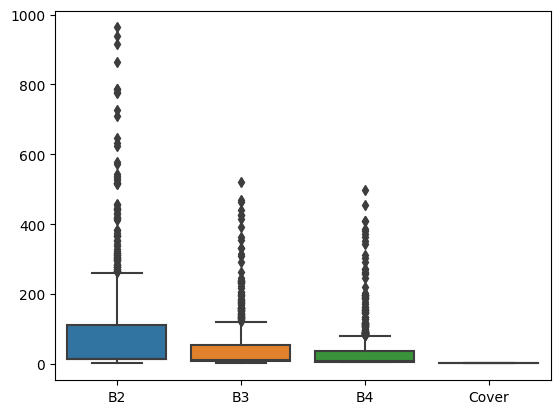

In [ ]:
sns.boxplot(data3_ndup)

KeyError: ignored

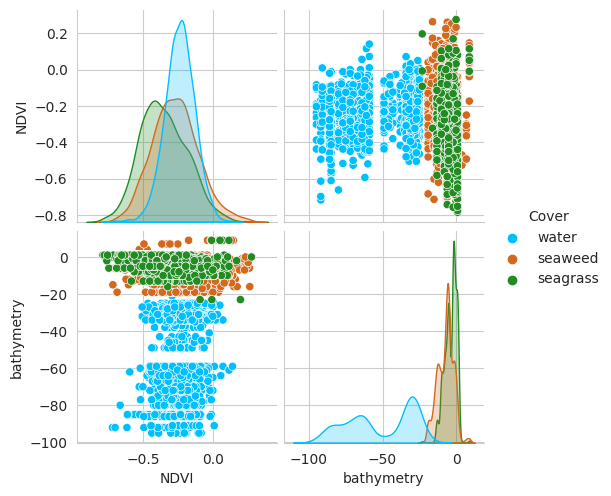

In [ ]:
pairplot_small(data)

# OBIA continued


In [ ]:
vis_params_sw = {'color':'#7b3e00'}
vis_params_sg = {'color':'1c5f2c'} 
vis_params_water = {'color':'#0d98ba'}  

Map.addLayer(sample_sg, vis_params_sg, 'seagrass samples')
Map.addLayer(sample_sw, vis_params_sw, 'seaweed samples')
Map.addLayer(sample_water, vis_params_water, 'water samples')
Map

Map(bottom=24205.399963378906, center=[43.70203416790044, -70.48773223534226], controls=(WidgetControl(options…

In [ ]:
# Locally store dat a
# 1) data = data_composite_min_11_test 
# 2) data.head()               # Check how the data looks 
# 3) data.describe()
# 4) data.isnull().sum().sum() # Check for null-values 
# 5) data.columns              # Found mix-up mistake of columns
# 6) data = data.drop(['geometry','B2', 'B3','B4','B8', 'NDVI', 'bathymetry'], axis=1) # Remove duplicates created 
# 7) data = data.drop(['geometry'], axis=1)
# 8) data.rename(columns={'B2_mean': 'B2', 'B3_mean': 'B3', 'B4_mean':'B4', 'B8_mean':'B8','NDVI_mean':'NDVI', 'bathymetry_mean': 'bathymetry'}, inplace=True)
# 9) data.head()                # Verify that our fix worked
# 10) data = data.sample(frac=1) # Randomize the data
# 11) data.to_csv(r'/content/OBIA11test.csv', index=False) 

In [ ]:
print(len(data))
print(data['Cover'].value_counts())
data.aggregate(['min','max','mean','median'])

4164
1    1388
2    1388
3    1388
Name: Cover, dtype: int64


B2          B3          B4           B8      NDVI  bathymetry  \
min      11.445064   72.611548    7.959170     4.000000 -0.887324   -95.00000   
max     414.216802  580.094922  508.628516  1204.000000  0.275949     9.00000   
mean    157.683654  176.932218   65.909692    53.607829 -0.288229   -20.99976   
median  155.026305  166.274654   61.596720    45.000000 -0.283951    -8.00000   

        Cover  
min       1.0  
max       3.0  
mean      2.0  
median    2.0

In [ ]:
data.head()

geometry          B2          B3         B4  B8  \
2127  POINT (-69.84626 43.74277)  107.487388  185.113466  57.134909  50   
2163  POINT (-70.12650 43.71369)   62.087794  127.566923  17.486048  96   
1729  POINT (-69.70015 43.87059)  210.095864  305.280065  88.270159  25   
2361  POINT (-70.11682 43.71576)  141.756813  208.260089  63.621469  34   
542   POINT (-69.07918 43.41019)   89.547932   90.640032  13.135080  13   

          NDVI  bathymetry  Cover  
2127 -0.212598          -1      3  
2163  0.263158          -9      3  
1729 -0.593496          -8      2  
2361 -0.387387          -6      3  
542  -0.161290        -156      1

In [ ]:
'''
Code for testing differnt sizes of numPixels.

# for i in [10, 30, 100, 200, 5000]:
# for i in [100, 110, 130, 150]:
# for i in [100000, 50000, 70000, 200000]:

sample_sg = objectPropertiesImage.sample(**{
'region': seaweed_shp,
'numPixels':110,  
'geometries': True,
'seed' :3,
'scale': 10,   # Set to 10 as our resolution is 10-meters
})

print(sample_sg.size().getInfo())
'''

39


# Cut ee.Image into 5 regions for test and validation later on

In [ ]:
# Create 6 feautres
features = geemap.fishnet(roi, rows = 2, cols = 3, delta = 0)
Map.addLayer(features, {}, 'grid')
print('Number of features from grid: ', features.size().getInfo())
feature_list = features.toList(6)
print(feature_list.getInfo())
Map

Number of features from grid:  6
[{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-70.248302, 43.27020599999997], [-69.79333466666667, 43.27020599999997], [-69.79333466666667, 43.758423257434075], [-70.248302, 43.758423257434075], [-70.248302, 43.27020599999997]]]}, 'id': '0_0', 'properties': {'east': -69.79333466666667, 'north': 43.758423257434075, 'south': 43.27020599999997, 'west': -70.248302}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-69.79333466666667, 43.27020599999997], [-69.33836733333334, 43.27020599999997], [-69.33836733333334, 43.758423257434075], [-69.79333466666667, 43.758423257434075], [-69.79333466666667, 43.27020599999997]]]}, 'id': '0_1', 'properties': {'east': -69.33836733333334, 'north': 43.758423257434075, 'south': 43.27020599999997, 'west': -69.79333466666667}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-69.33836733333332, 43.2702

Map(bottom=48060.59999084473, center=[43.80162935726774, -69.6166774407069], controls=(WidgetControl(options=[…

In [ ]:
# Extract metadata on the second feautre from our feautre list
f2_meta = feature_list.getInfo()[1]

# Get coordinates from the second feature
f2 = feature_list.getInfo()[1]['geometry']['coordinates'][0]

# Create geometry from cooridnates of second feature
# Source code:. https://developers.google.com/earth-engine/guides/geometries Accessed: 02.03.2023
f2_geometry = ee.Geometry.Polygon(f2)
type(f2_geometry)

In [ ]:
# Collect all the geometries from the grid created above and store them in a list. 
meta = []
img_list = []

for feat in range(1,features.size().getInfo(),1):
  f_coord = feature_list.getInfo()[feat]['geometry']['coordinates'][0]
  f_geometry = ee.Geometry.Polygon(f_coord)
  meta.append(f_geometry)
  img = image.clip(f_geometry)
  img_list.append(img)

  len(img_list)

In [ ]:
#Create an ImageCollection from the FeatureCollection
images = features.map(lambda feature: ee.Image(ee.Number(feature.get('foo'))))
type(images)

In [ ]:
collectionFromConstructor = ee.ImageCollection(img_list)
type(collectionFromConstructor)

ee.imagecollection.ImageCollection

In [ ]:
# Code inspired from Open AI

third_image =  ee.Image(collectionFromConstructor.toList(collectionFromConstructor.size()).get(3))
second_image = ee.Image(collectionFromConstructor.toList(collectionFromConstructor.size()).get(1))


In [ ]:
# Display geometry of second feature
# source code: https://developers.google.com/earth-engine/guides/feature_collection_info. Accessed: 02.03.2023

vis_params = {"bands": [ 'B2', 'B3', 'B4'], "min": 0, "max": 1500, "gamma": 1.5}
Map.addLayer(third_image, vis_params, 'feature 1')
# print('First watershed', sheds.first());
Map

Map(bottom=48061.0, center=[43.80162935726774, -69.6166774407069], controls=(WidgetControl(options=['position'…

# Retrieve locally stored data

In [ ]:
# Load datasets 

# Data with 11 feautres 
obia_train = pd.read_csv('/content/OBIA_train11.csv')
obia_test=  pd.read_csv('/content/OBIA11test.csv')

# Data with 7 feautres 
pb6_train = pd.read_csv('/content/PB_train6.csv')
pb6_test = pd.read_csv('/content/PB6test.csv')

# Data with 3 feautres 
pb3_train = pb6_train.loc[:,['B2','B3','B4','Cover']]
pb3_test = pb6_test.loc[:,['B2','B3','B4','Cover']]

# Checking data 

In [ ]:
# OB1: See that the data is not shuffled in relation to the class labels
# OB2: observe that the values do not present wavlengths, put pixel-values of 16-bit
# data3_ndup.head() 
# data3_ndup.aggregate(['min','max','mean','median'])

# OB3: There are 720 samples of training data
# data3_ndup['Cover'].count()

# OB4: The training data is balanced with 240 samples for each class
# data3_ndup['Cover'].value_counts()

# OB5: OBserve that the test data has negative values, need to create a test-set without negative values later
# data3t_ndup.aggregate(['min','max','mean','median'])

# Visualization of raw data 


In [ ]:
def pairplot(data):
  if str(type(data.iloc[:,-1][0])) != str:
    # Convert integers into meaningfull labels
    row_lables = data.iloc[:,-1].replace([1,2,3], ['water','seaweed','seagrass'], inplace=True)
  else: 
    print('Your class lables are already converted to meaningfull names :) \n')

  # Get the class column name
  label = data.columns[-1]

  # plot # Link to colors: https://medium.com/swlh/how-to-create-a-seaborn-palette-that-highlights-maximum-value-f614aecd706b
  return sns.pairplot(data, hue=label, height=2.5, palette = ['deepskyblue','chocolate', 'forestgreen'])

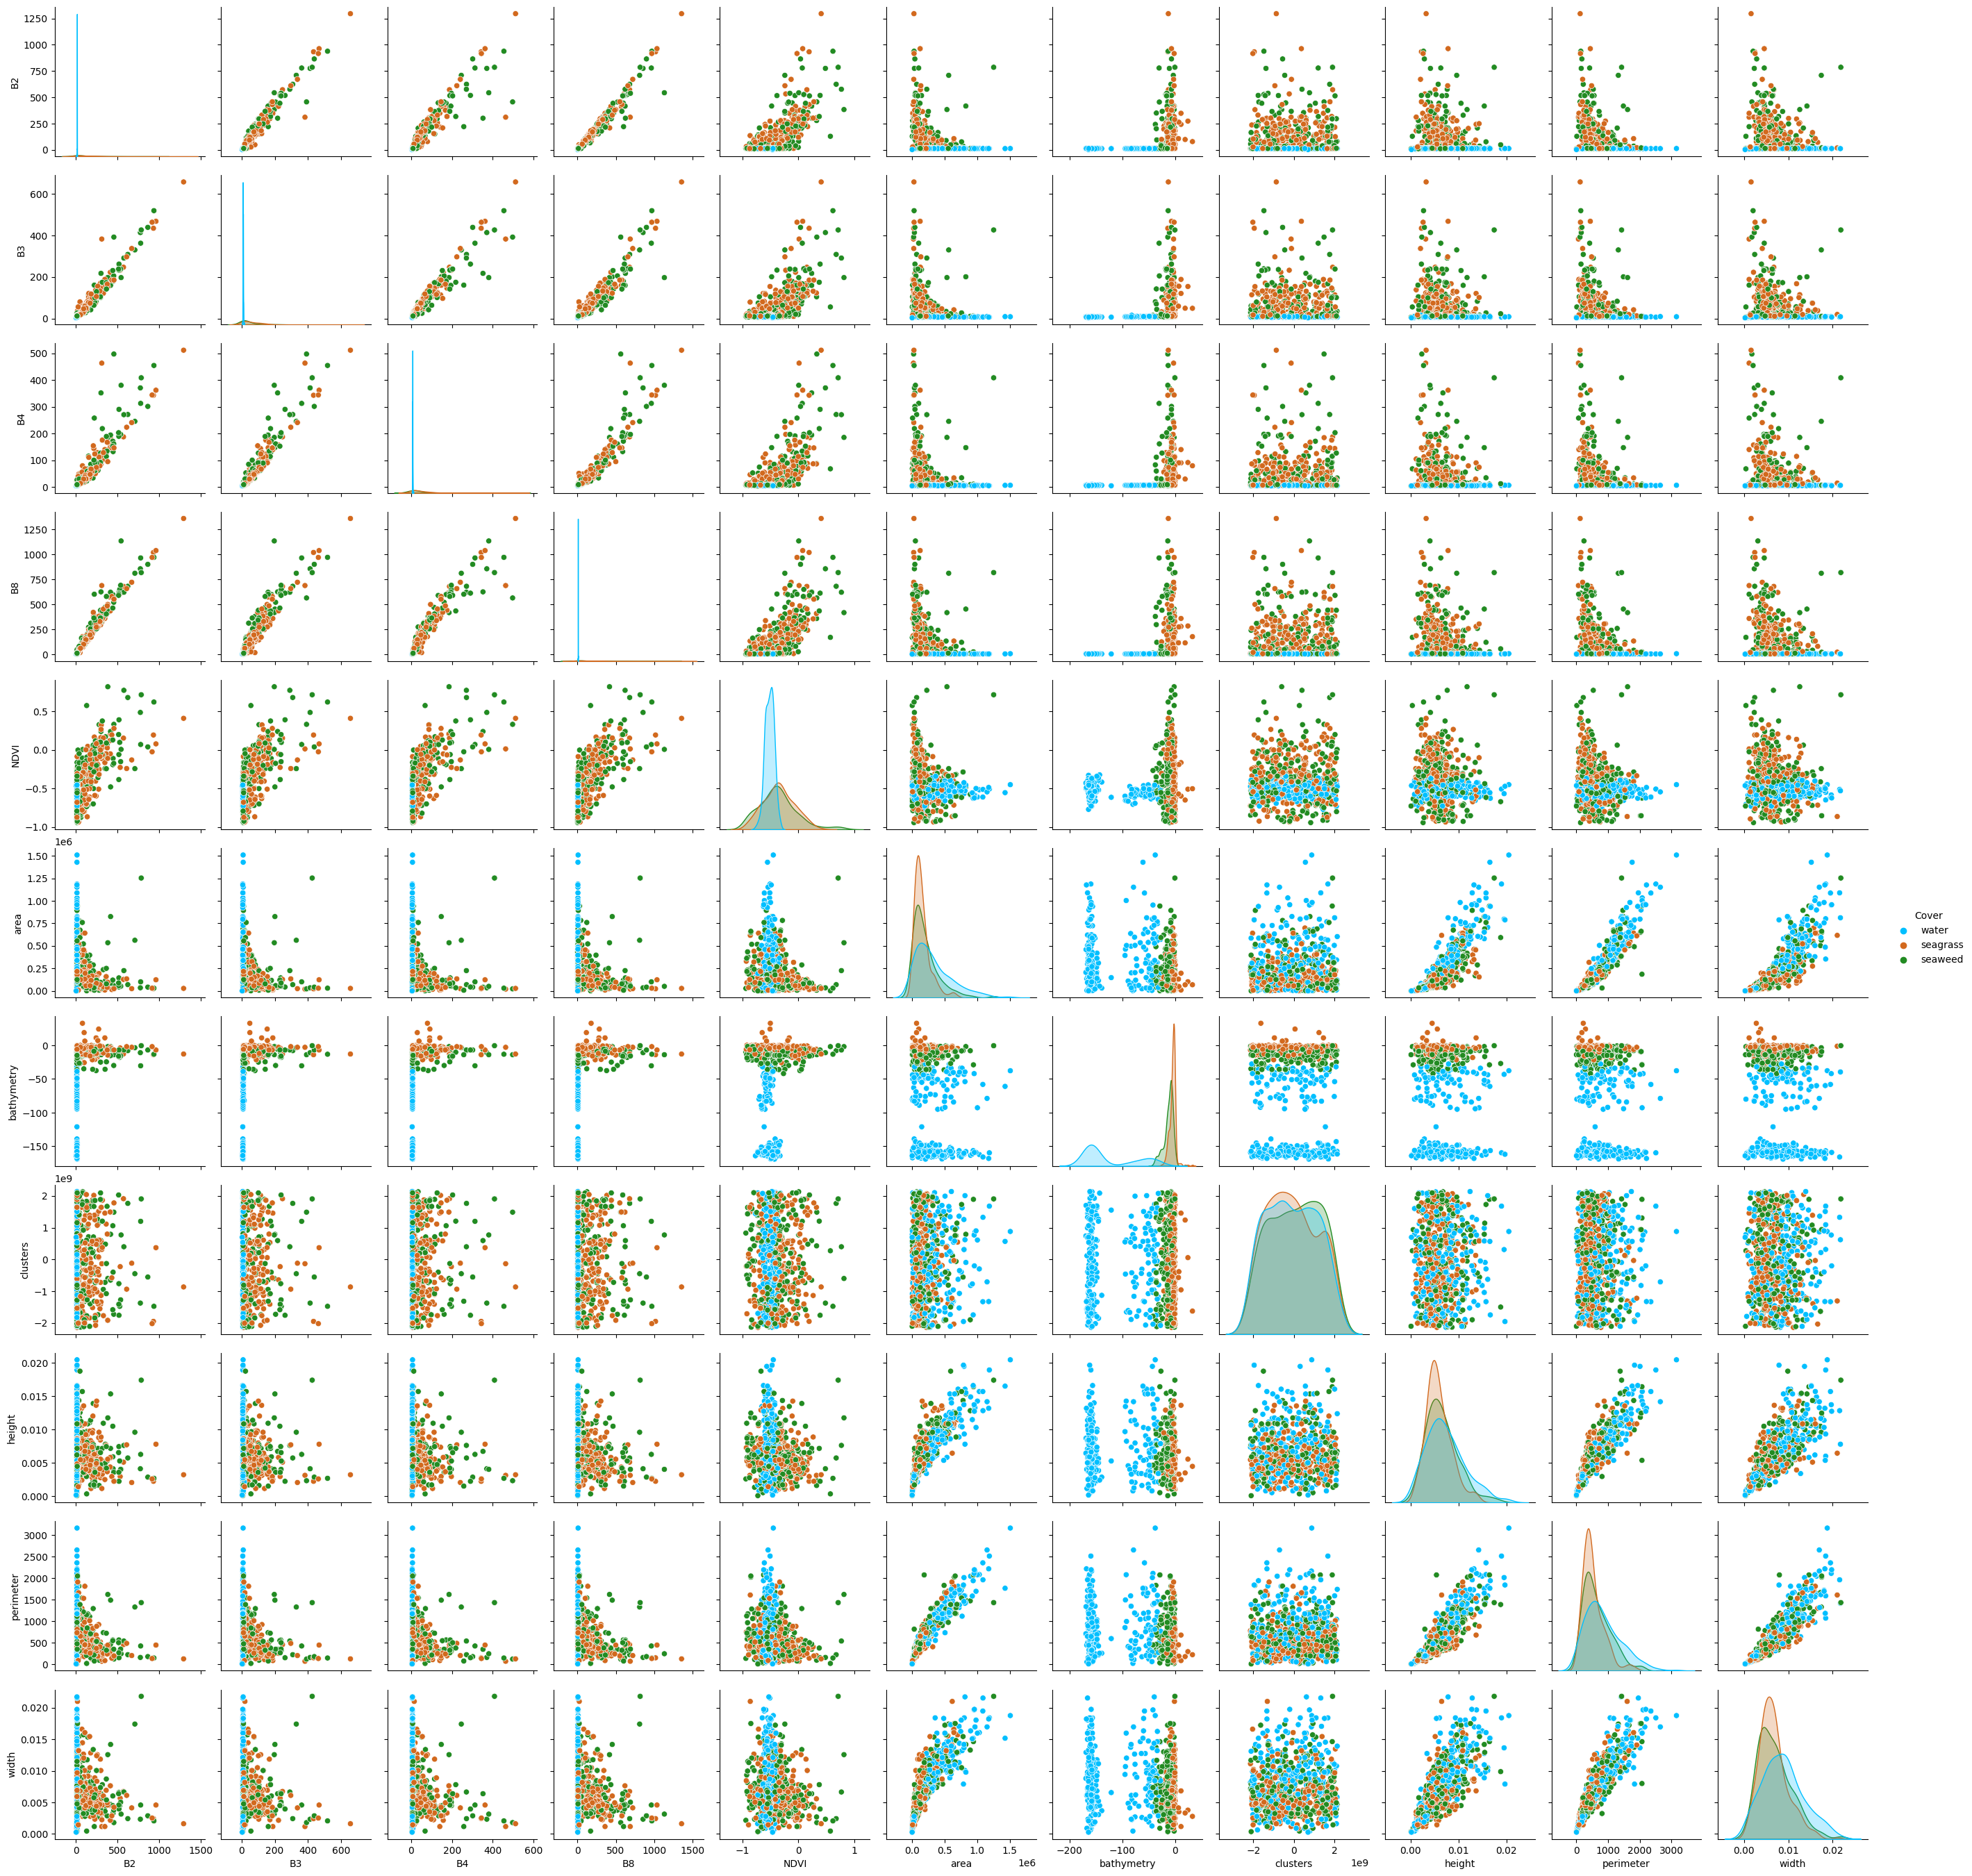

In [ ]:
pairplot(obia_train)

In [ ]:
def pairplot_small(data):

  # Get the class column name
  label = data.columns[-1]

  if str(type(data.iloc[:,-1][0])) != str:
    # Convert integers into meaningfull labels
    row_lables = data.iloc[:,-1].replace([1,2,3], ['water','seaweed','seagrass'], inplace=True)
  else: 
    print('Your class lables are already converted to meaningfull names :) \n')

  # Check length of data, choose a portion of the features to be displayd for clarity
  if len(data.columns) < 5:
    # The column containing the class lables must be included
    df_small = data.iloc[:,[0,1,-1]]

  elif len(data.columns) < 9:
    
    df_small = data.iloc[:,[5,6,-1]]

  else:
    df_small = data.iloc[:,[4,5,6,-1]]

  sns.set_style("whitegrid")
  sns.set_context(font_scale=1)
  sns.pairplot(df_small, hue=label, palette = ['deepskyblue','chocolate', 'forestgreen'])	


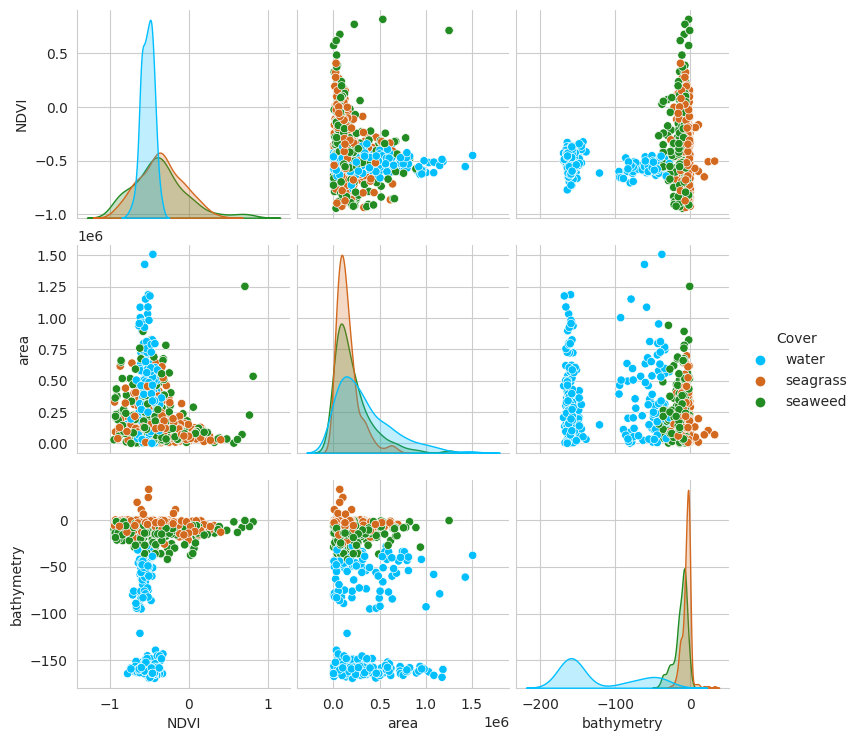

In [ ]:
pairplot_small(obia_train)

# Data visualization: Statistical testing of data 
- Check for normal distribution

Seems like my training data is not noramlly distributed, while the training data is

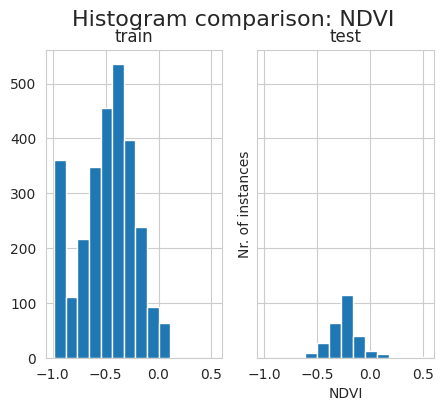

In [ ]:
fig, [ax1, ax2] = plt.subplots(
    nrows=1, ncols=2, figsize = (5,4), sharex = True, sharey= True)
fig.suptitle(f'Histogram comparison: NDVI', fontsize=16)
plt.xlabel('NDVI')
plt.ylabel('Nr. of instances')
ax1.set_title(f"train", fontdict={"fontsize": 12})
ax1.hist(pb6_train['NDVI'])
ax2.set_title(f"test", fontdict={"fontsize": 12})
ax2.hist(pb6_test['NDVI'])
plt.show()

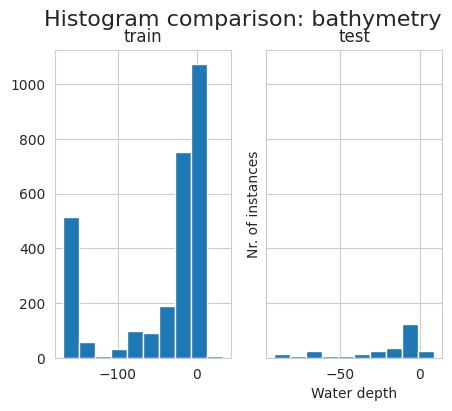

In [ ]:
fig, [ax1, ax2] = plt.subplots(
    nrows=1, ncols=2, figsize = (5,4), sharex = False, sharey= True)
fig.suptitle(f'Histogram comparison: bathymetry', fontsize=16)
plt.xlabel('Water depth')
plt.ylabel('Nr. of instances')
ax1.set_title(f"train", fontdict={"fontsize": 12})
ax1.hist(pb6_train['bathymetry'])
ax2.set_title(f"test", fontdict={"fontsize": 12})
ax2.hist(pb6_test['bathymetry'])
plt.show()

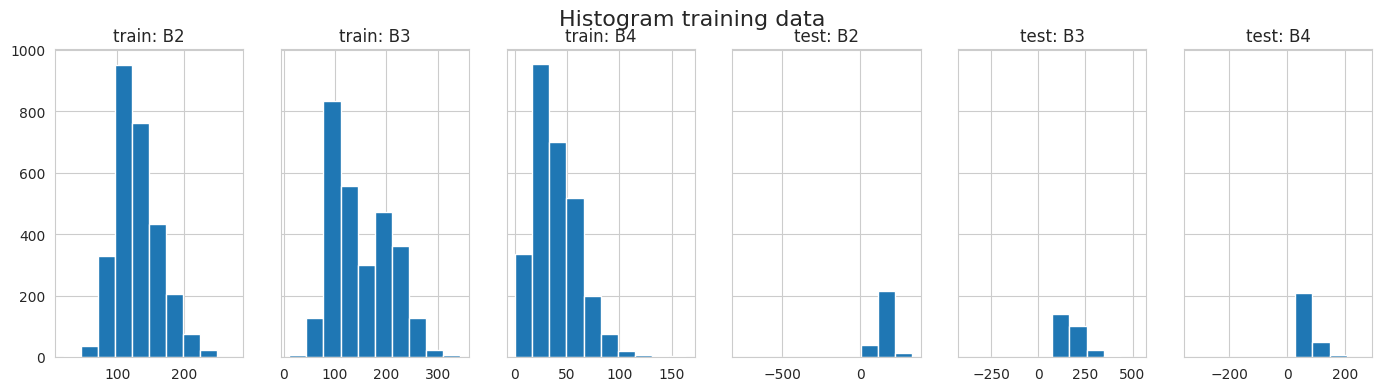

In [ ]:
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(
    nrows=1, ncols=6, figsize = (17,4), sharex = False, sharey= True)
fig.suptitle(f'Histogram training data', fontsize=16)
ax1.set_title(f"train: B2", fontdict={"fontsize": 12})
ax1.hist(pb6_train['B2'])
ax2.set_title(f"train: B3", fontdict={"fontsize": 12})
ax2.hist(pb6_train['B3'])
ax3.set_title(f"train: B4", fontdict={"fontsize": 12})
ax3.hist(pb6_train['B4'])

ax4.set_title(f"test: B2", fontdict={"fontsize": 12})
ax4.hist(pb6_test['B2'])
ax5.set_title(f"test: B3", fontdict={"fontsize": 12})
ax5.hist(pb6_test['B3'])
ax6.set_title(f"test: B4", fontdict={"fontsize": 12})
ax6.hist(pb6_test['B4'])
plt.show()

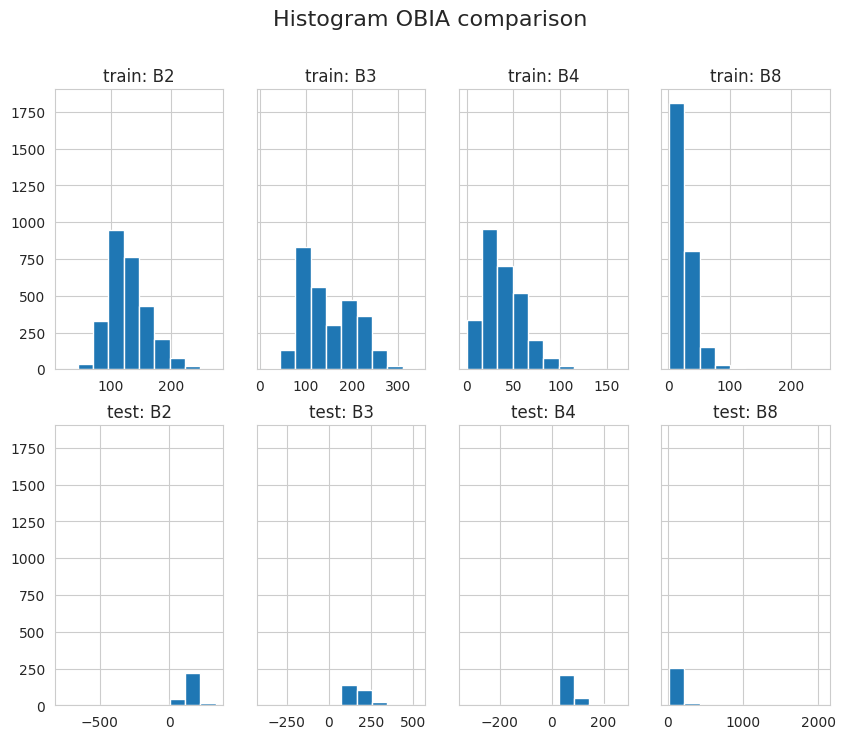

In [ ]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, figsize = (10,8), sharex = False, sharey= True)
fig.suptitle(f'Histogram OBIA comparison', fontsize=16)
axs[0,0].set_title(f"train: B2", fontdict={"fontsize": 12})
axs[0,0].hist(pb6_train['B2'])
axs[0,1].set_title(f"train: B3", fontdict={"fontsize": 12})
axs[0,1].hist(pb6_train['B3'])
axs[0,2].set_title(f"train: B4", fontdict={"fontsize": 12})
axs[0,2].hist(pb6_train['B4'])
axs[0,3].set_title(f"train: B8", fontdict={"fontsize": 12})
axs[0,3].hist(pb6_train['B8'])


axs[1,0].set_title(f"test: B2", fontdict={"fontsize": 12})
axs[1,0].hist(pb6_test['B2'])
axs[1,1].set_title(f"test: B3", fontdict={"fontsize": 12})
axs[1,1].hist(pb6_test['B3'])
axs[1,2].set_title(f"test: B4", fontdict={"fontsize": 12})
axs[1,2].hist(pb6_test['B4'])
axs[1,3].set_title(f"test: B8", fontdict={"fontsize": 12})
axs[1,3].hist(pb6_test['B8'])
plt.show()

In [ ]:
fig = sm.qqplot(obia_train['B4'], line='s')

In [ ]:
obia_train.columns

Index(['B2', 'B3', 'B4', 'B8', 'NDVI', 'area', 'bathymetry', 'clusters',
       'height', 'perimeter', 'width', 'Cover'],
      dtype='object')

Text(0.5, 1.0, 'test: perimeter')

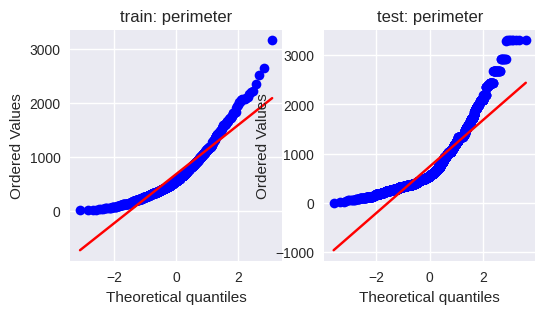

In [ ]:
plt.figure(figsize=(6,3))
fig.suptitle(f'QQ-plots OBIA training comparison', fontsize=16)
ax = plt.subplot(1,2,1)
res1 = stats.probplot(obia_train['perimeter'], dist="norm", plot=ax)
ax.set_title('train: perimeter')

# Q-Q plot
ax1 = plt.subplot(1,2,2)
res = stats.probplot(obia_test['perimeter'], dist="norm", plot=ax1)
# Divide by 1000 because : https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED. Accessed 04.04.23
ax1.set_title('test: perimeter')
# For details see: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html


In [ ]:
#perform Shapiro-Wilk test for normality
alpha = 0.05 # We say a features does not come from a normal distribution if the p-value is < 0.05 (5%)

for feature in obia_train.columns:
  shapiro_test =  shapiro(obia_train[feature])
  pval = shapiro_test.pvalue
  print(f'shapiro_results for obia training features {feature}: {shapiro_test}')
  if pval < alpha:
    print(f'feature {feature} does not come from a normal distribution')
  else: 
    print(f'feature {feature} does come from a normal distribution. Hurray!')

shapiro_results for obia features B2: ShapiroResult(statistic=0.5852579474449158, pvalue=1.406458045270461e-38)
feature B2 does not come from a normal distribution
shapiro_results for obia features B3: ShapiroResult(statistic=0.5654969811439514, pvalue=3.177800197666461e-39)
feature B3 does not come from a normal distribution
shapiro_results for obia features B4: ShapiroResult(statistic=0.5169216990470886, pvalue=1.0243631904060845e-40)
feature B4 does not come from a normal distribution
shapiro_results for obia features B8: ShapiroResult(statistic=0.616261899471283, pvalue=1.6368044957710688e-37)
feature B8 does not come from a normal distribution
shapiro_results for obia features NDVI: ShapiroResult(statistic=0.9348615407943726, pvalue=2.0547788455637847e-17)
feature NDVI does not come from a normal distribution
shapiro_results for obia features area: ShapiroResult(statistic=0.7980481386184692, pvalue=2.656375287909106e-29)
feature area does not come from a normal distribution
shapir

In [ ]:
#perform Shapiro-Wilk test for normality
alpha = 0.05 # We say a features does not come from a normal distribution if the p-value is < 0.05 (5%)

for feature in obia_test.columns:
  shapiro_test =  shapiro(obia_test[feature])
  pval = shapiro_test.pvalue
  print(f'shapiro_results for obia test features {feature}: {shapiro_test}')
  if pval < alpha:
    print(f'feature {feature} does not come from a normal distribution')
  else: 
    print(f'feature {feature} does come from a normal distribution. Hurray!')

shapiro_results for obia test features B2: ShapiroResult(statistic=0.9684646725654602, pvalue=1.8652040190712142e-29)
feature B2 does not come from a normal distribution
shapiro_results for obia test features B3: ShapiroResult(statistic=0.8688913583755493, pvalue=0.0)
feature B3 does not come from a normal distribution
shapiro_results for obia test features B4: ShapiroResult(statistic=0.85811847448349, pvalue=0.0)
feature B4 does not come from a normal distribution
shapiro_results for obia test features B8: ShapiroResult(statistic=0.3091527819633484, pvalue=0.0)
feature B8 does not come from a normal distribution
shapiro_results for obia test features NDVI: ShapiroResult(statistic=0.9349657297134399, pvalue=1.7174356017718888e-39)
feature NDVI does not come from a normal distribution
shapiro_results for obia test features area: ShapiroResult(statistic=0.7360504269599915, pvalue=0.0)
feature area does not come from a normal distribution
shapiro_results for obia test features bathymetry:

In [ ]:
#perform Shapiro-Wilk test for normality
alpha = 0.05 # We say a features does not come from a normal distribution if the p-value is < 0.05 (5%)

for feature in pb6_train.columns:
  shapiro_test =  shapiro(pb6_train[feature])
  pval = shapiro_test.pvalue
  print(f'shapiro_results for PB train features {feature}: {shapiro_test}')
  if pval < alpha:
    print(f'feature {feature} does not come from a normal distribution')
  else: 
    print(f'feature {feature} does come from a normal distribution. Hurray!')

shapiro_results for PB train features B2: ShapiroResult(statistic=0.972472071647644, pvalue=7.138107612910745e-23)
feature B2 does not come from a normal distribution
shapiro_results for PB train features B3: ShapiroResult(statistic=0.9433695673942566, pvalue=1.3935779402585924e-31)
feature B3 does not come from a normal distribution
shapiro_results for PB train features B4: ShapiroResult(statistic=0.9444804191589355, pvalue=2.5303007258088382e-31)
feature B4 does not come from a normal distribution
shapiro_results for PB train features B8: ShapiroResult(statistic=0.80845046043396, pvalue=0.0)
feature B8 does not come from a normal distribution
shapiro_results for PB train features NDVI: ShapiroResult(statistic=0.9709124565124512, pvalue=1.740151741815013e-23)
feature NDVI does not come from a normal distribution
shapiro_results for PB train features bathymetry: ShapiroResult(statistic=0.6987107992172241, pvalue=0.0)
feature bathymetry does not come from a normal distribution
shapiro_r

In [ ]:
#perform Shapiro-Wilk test for normality
alpha = 0.05 # We say a features does not come from a normal distribution if the p-value is < 0.05 (5%)

for feature in pb6_test.columns:
  shapiro_test =  shapiro(pb6_test[feature])
  pval = shapiro_test.pvalue
  print(f'shapiro_results for PB test features {feature}: {shapiro_test}')
  if pval < alpha:
    print(f'feature {feature} does not come from a normal distribution')
  else: 
    print(f'feature {feature} does come from a normal distribution. Hurray!')

shapiro_results for PB test features B2: ShapiroResult(statistic=0.5899404287338257, pvalue=4.425462346635563e-25)
feature B2 does not come from a normal distribution
shapiro_results for PB test features B3: ShapiroResult(statistic=0.820919930934906, pvalue=3.6781211285713466e-17)
feature B3 does not come from a normal distribution
shapiro_results for PB test features B4: ShapiroResult(statistic=0.7325465679168701, pvalue=8.560009906551816e-21)
feature B4 does not come from a normal distribution
shapiro_results for PB test features B8: ShapiroResult(statistic=0.38257819414138794, pvalue=1.3752042582586296e-29)
feature B8 does not come from a normal distribution
shapiro_results for PB test features NDVI: ShapiroResult(statistic=0.9380836486816406, pvalue=2.3394932657794243e-09)
feature NDVI does not come from a normal distribution
shapiro_results for PB test features bathymetry: ShapiroResult(statistic=0.7820645570755005, pvalue=6.825755862034982e-19)
feature bathymetry does not come fr

# Spectral signature for each class

In [ ]:
def spectral_reflectance(data):
  dataframe = pd.DataFrame(columns = list(data.columns))
  water = pd.DataFrame(columns = list(data.columns))
  seagrass = pd.DataFrame(columns = list(data.columns))
  seaweed = pd.DataFrame(columns = list(data.columns))

  for i in range(0, len(data['Cover']), 1):
    if data['Cover'][i] == 1 or data['Cover'][i] == 'water'  :  
      water.loc[str(i)] = list(data.loc[i])
    elif data['Cover'][i] == 2 or data['Cover'][i] == 'seaweed': 
      seaweed.loc[str(i)] = list(data.loc[i])
    else:
      seagrass.loc[str(i)] = list(data.loc[i])


  spec_signature_water = []
  spec_signature_seaweed = []
  spec_signature_seagrass = []


  for band in water.columns[:-1]:
    b = water[band].mean()
    spec_signature_water.append(b)

  for band in seaweed.columns[:-1]:
    b = seaweed[band].mean()
    spec_signature_seaweed.append(b)


  for band in seagrass.columns[:-1]:
    b =seagrass[band].mean()
    spec_signature_seagrass.append(b)

  labels = list(data.columns[:-1])

  plt.plot(labels, spec_signature_water, label='water')
  plt.plot(labels, spec_signature_seaweed, label='seaweed')
  plt.plot(labels, spec_signature_seagrass, label='seagrass')


  plt.title('Spectral refletance')
  plt.xlabel('Bands')
  plt.ylabel('Average values of bands')
  plt.legend()
  return plt.show()


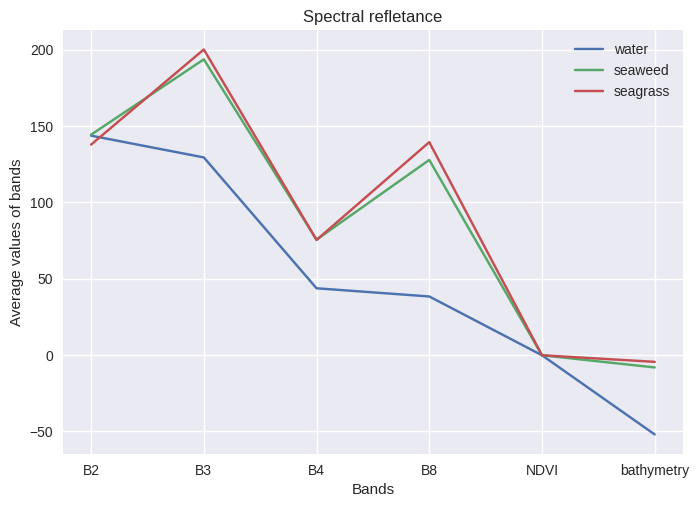

In [ ]:
spectral_reflectance(pb6_test) # New test data only for PB

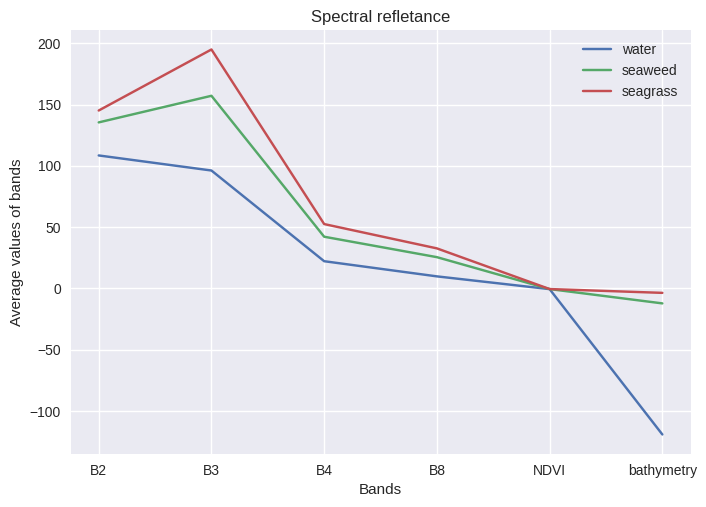

In [ ]:
spectral_reflectance(pb6_train) # New test data only for PB

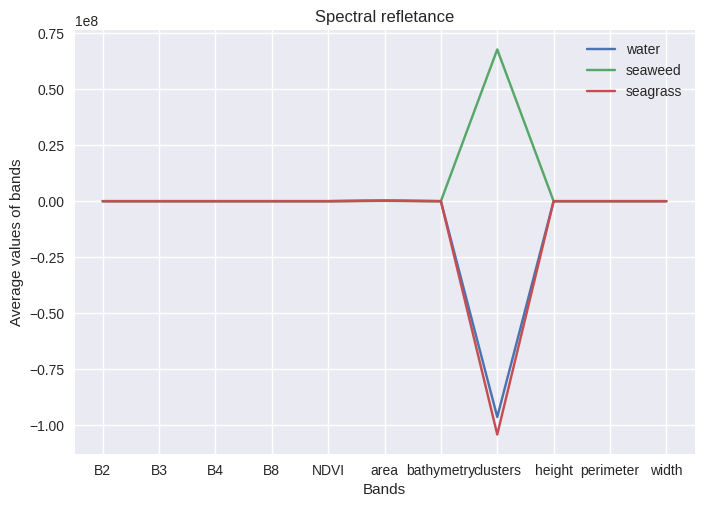

In [ ]:
spectral_reflectance(obia_train) # New test data only for PB

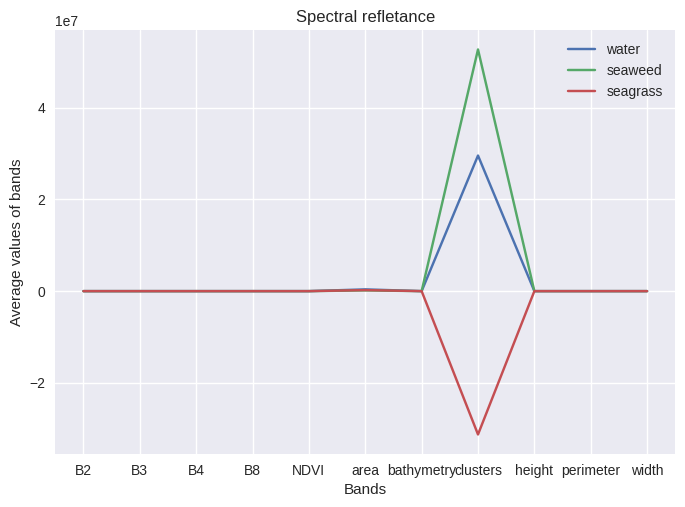

In [ ]:
spectral_reflectance(obia_test) # New test data only for PB

# Bias-variance trade-off graph

In [ ]:
def train_val(data):
  y = data.iloc[:,-1]            # Get class lables
  label = y.name                 # Get the name of class label
  X = data.drop(label, axis = 1) # Get only feaures 

  # Standardize the data 
  X_std = X #StandardScaler().fit_transform(X)
  # Training dataset set to 80 %
  X_train, X_rem, y_train, y_rem = train_test_split(X_std, y, train_size=0.8, random_state=42)
  # Validation and test dataset set to 10% each
  X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

  # Initializing the estimator
  rfc=RandomForestClassifier(random_state=42)

  param_grid = {'n_estimators':[int(x) for x in np.linspace(start=10, stop = 30, num = 5)],
              'max_features': ['sqrt', 'log2', None],
              'max_depth':[2,4,10],
              'min_samples_split': [2,5],
              'min_samples_leaf':[1,2],
              'bootstrap':[True, False],
              }

  CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv= 5, refit=True)
  CV_rfc.fit(X, y)
  train_sizes, train_scores, test_scores = learning_curve(estimator = CV_rfc.best_estimator_,
                                                          X=X_train,
                                                          y=y_train,
                                                          train_sizes=np.linspace(0.03,1,5),
                                                          cv=10,
                                                          n_jobs=-1)

  train_mean = np.mean(train_scores,axis=1)
  train_std = np.std(train_scores,axis=1)
  test_mean = np.mean(test_scores,axis=1)
  test_std = np.std(test_scores,axis=1)

  f = plt.figure()
  f.set_figwidth(6)
  f.set_figheight(6)
    
  plt.plot(train_sizes, train_mean,
          color='blue', marker='o',
          markersize=5, label='Training accuracy')

  plt.fill_between(train_sizes,
                  train_mean + train_std,
                  train_mean - train_std,
                  alpha=0.15, color='blue')

  plt.plot(train_sizes, test_mean,
          color='green', linestyle='--', marker='s',
          markersize=5, label='Validation accuracy')

  plt.fill_between(train_sizes,
                  test_mean + test_std,
                  test_mean - test_std,
                  alpha=0.15, color='green')
  
  plt.xlabel('Number of training examples', fontsize = 15)
  plt.ylabel('Accuracy', fontsize = 15 )
  plt.xticks(fontsize = 15)
  plt.yticks(fontsize = 15)
  plt.legend(loc='lower right', prop={'size': 15})
  plt.ylim([0.0,1.03])
  plt.title('Learning curve: number of training examples', fontsize = 20)
  plt.grid()
  plt.tight_layout()
  return plt.show()


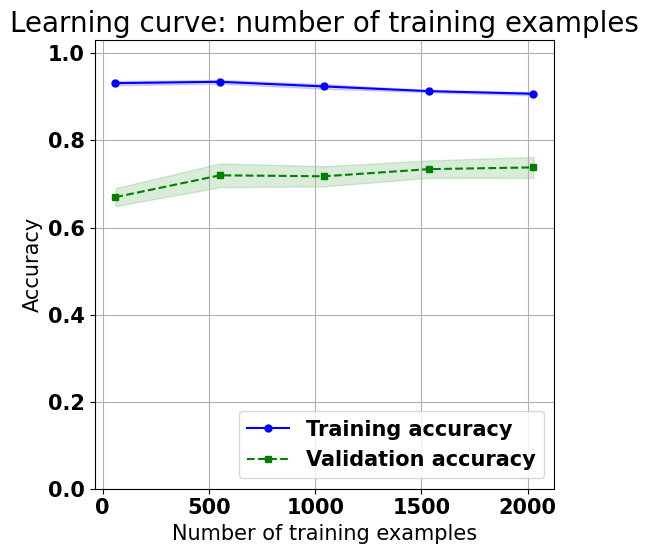

In [ ]:
train_val(pb3_train) # with minmaxscalar


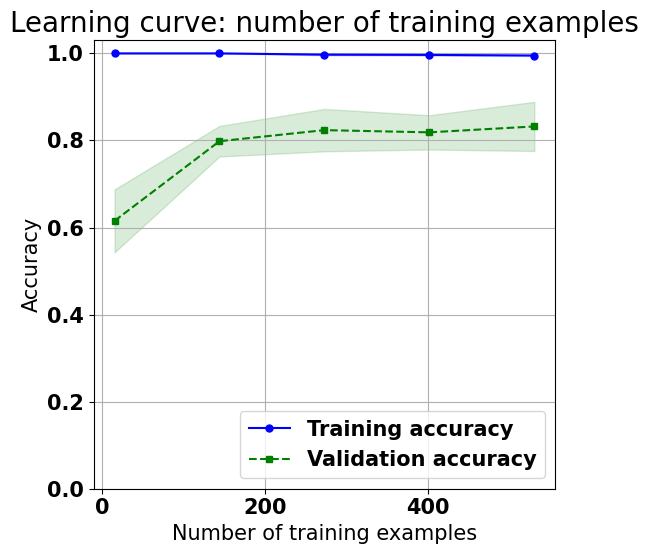

In [ ]:
train_val(obia_train) # with standardscalar


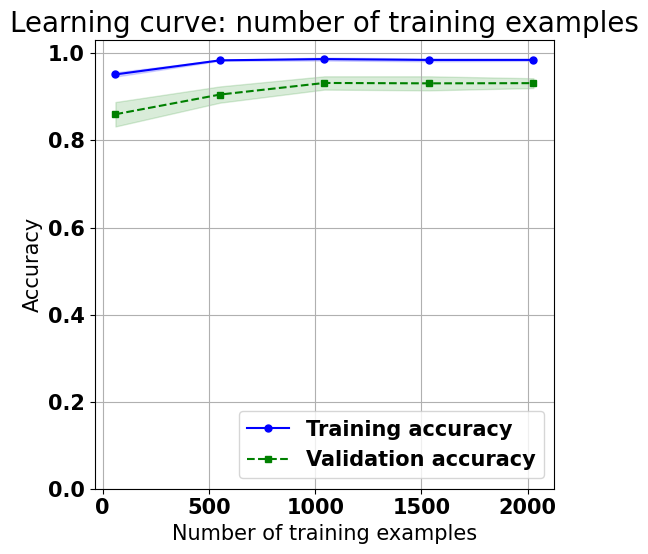

In [ ]:
train_val(pb6_train) # with standardscalar


# Validation curve 



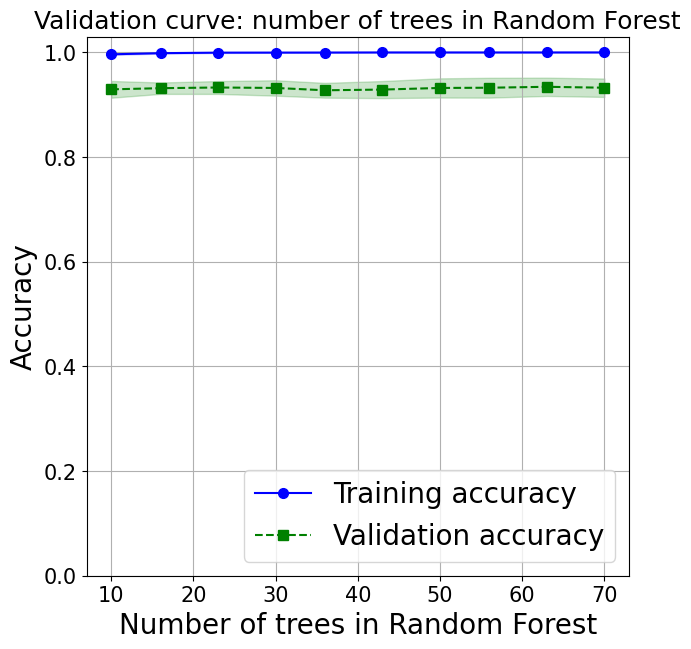

In [ ]:
def val_curve(data):
  y = data.iloc[:,-1]            # Get class lables
  label = y.name                 # Get the name of class label
  X = data.drop(label, axis = 1) # Get only feaures 

  # Standardize the data 
  X_std = X #StandardScaler().fit_transform(X)
  # Training dataset set to 80 %
  X_train, X_rem, y_train, y_rem = train_test_split(X_std, y, train_size=0.8, random_state=42)
  # Validation and test dataset set to 10% each
  X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

  # Initializing the estimator
  rfc=RandomForestClassifier(random_state=42)

  #Number of trees in RF
  n_estimators = [int(x) for x in np.linspace(start=10, stop = 70, num = 10)]

  train_scores, test_scores = validation_curve(estimator = rfc,
                                            X=X_train,
                                            y=y_train,
                                            param_name='n_estimators',
                                            param_range=n_estimators,
                                            cv=10)

  train_mean = np.mean(train_scores,axis=1)
  train_std = np.std(train_scores,axis=1)
  test_mean = np.mean(test_scores,axis=1)
  test_std = np.std(test_scores,axis=1)

  f = plt.figure()
  f.set_figwidth(7)
  f.set_figheight(7)

  plt.plot(n_estimators, train_mean,
          color='blue', marker='o',
          markersize=7, label='Training accuracy')

  plt.fill_between(n_estimators,
                  train_mean + train_std,
                  train_mean - train_std,
                  alpha=0.20, color='blue')

  plt.plot(n_estimators, test_mean,
          color='green', linestyle='--', marker='s',
          markersize=7, label='Validation accuracy')

  plt.fill_between(n_estimators,
                  test_mean + test_std,
                  test_mean - test_std,
                  alpha=0.20, color='green')

  plt.grid()
  plt.xlabel('Number of trees in Random Forest',  fontsize = 20)
  plt.ylabel('Accuracy',  fontsize = 20)
  plt.xticks(fontsize = 15)
  plt.yticks(fontsize = 15)
  plt.legend(loc='lower right', prop={'size': 20})
  plt.ylim([0.0,1.03])
  plt.title('Validation curve: number of trees in Random Forest', fontsize = 18)
  return plt.show()

val_curve(pb6_train)

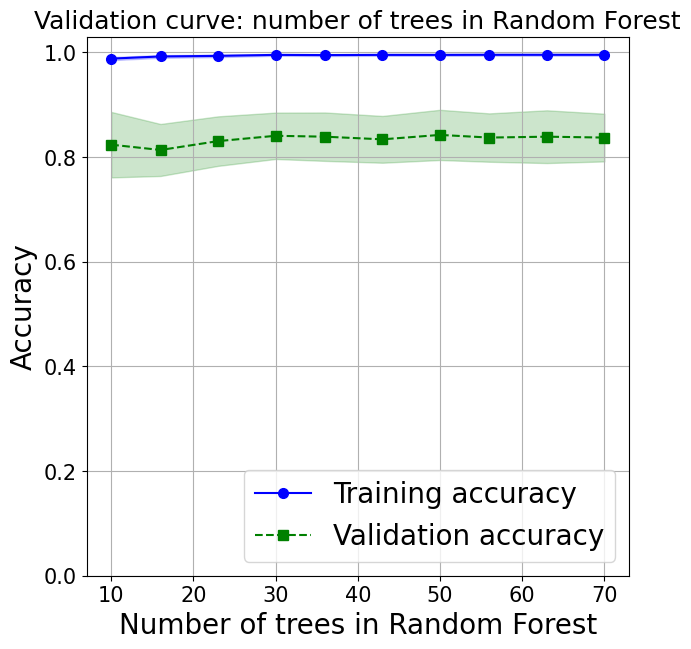

In [ ]:
val_curve(obia_train)

# SML: Random Forest Training data 

In [ ]:
def supervised_RF(data):
  '''
  Takes any dataset with X feautres and a column of y-values in.
  Function assumes the last column to contain the class-labels of the data
  '''
 
  data = data.sample(frac=1)     # Randomly shuffle data 
  y = data.iloc[:,-1]            # Get class lables
  label = y.name                 # Get the name of class label
  X = data.drop(label, axis = 1) # Get only feaures 

  # Standardize the data 
  X_std = X #StandardScaler().fit_transform(X)
  # Training dataset set to 80 %
  X_train, X_rem, y_train, y_rem = train_test_split(X_std, y, train_size=0.8, random_state=42)
  # Validation and test dataset set to 10% each
  X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

  rfc=RandomForestClassifier(random_state=42)

  param_grid = {'n_estimators':[int(x) for x in np.linspace(start=10, stop = 30, num = 5)], # List comprehension
              'max_features': ['sqrt', 'log2', None],
              'max_depth':[2,4,10],
              'min_samples_split': [2,5],
              'min_samples_leaf':[1,2],
              'bootstrap':[True, False],
              }

  CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10, refit=True)
  CV_rfc.fit(X_train, y_train)

  preds = CV_rfc.predict(X_valid)
  cm = confusion_matrix(y_valid, preds)
  mean_test_score_3f = CV_rfc.cv_results_['mean_test_score']
  return accuracy_score(y_valid, preds), len(X.columns), preds, y_valid, mean_test_score_3f

start3 = time.time()
results3 = supervised_RF(pb3_train)
print(f'SML classification with 3 features complete in: {(time.time() - start3)/60:,.2f} minutes')

start6 = time.time()
results6 = supervised_RF(pb6_train)
print(f'SML classification with 6 features complete in: {(time.time() - start6)/60:,.2f} minutes')

start11 = time.time()
results11 = supervised_RF(obia_train)
print(f'SML classification with 11 features complete in: {(time.time() - start11)/60:,.2f} minutes')

print(f'{results3[0]*100:,.2f}% where accuratly classified given 3 features')
print('-----------------------------------------------------------------')
print(f'{results6[0]*100:,.2f}% where accuratly classified given 6 features')
print('-----------------------------------------------------------------')
print(f'{results11[0]*100:,.2f}% where accuratly classified given 11 features ')
print('-----------------------------------------------------------------')


SML classification with 3 features complete in: 5.22 minutes
SML classification with 6 features complete in: 6.53 minutes
SML classification with 11 features complete in: 3.91 minutes
77.66% where accuratly classified given 3 features
-----------------------------------------------------------------
95.04% where accuratly classified given 6 features
-----------------------------------------------------------------
78.38% where accuratly classified given 11 features 
-----------------------------------------------------------------


# SML: Training accuracies

<ipython-input-7-e39a85d7c89f>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['3 ', '6 ',


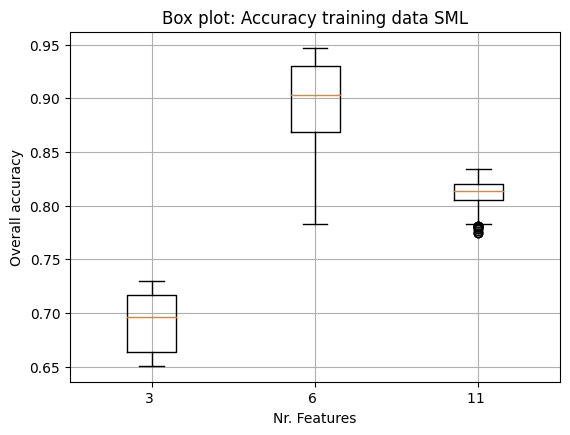

In [ ]:
# Box-plot function 
def boxplot(data_list):
  fig= plt.figure(figsize =(7, 5))
  
  # Creating axes instance
  ax1 = fig.add_axes([0,0, 0.7,0.7])
  # x-axis labels
  ax1.set_xticklabels(['3 ', '6 ',
                      '11 '])
  # Adding title
  plt.title("Box plot: Accuracy training data SML")
  # Creating plot
  bp = ax1.boxplot(data_list)
  plt.xlabel('Nr. Features')
  plt.ylabel('Overall accuracy')
  plt.grid()
  # show plot
  return plt.show()

data = [results3[4], results6[4], results11[4]]
boxplot(data)

In [ ]:
print(classification_report(results3[3],results3[2],target_names=['water','seaweed','seagrass']))

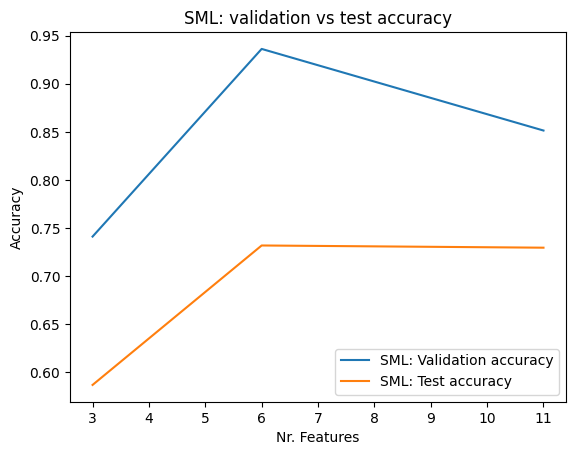

In [ ]:
# SML: Accuracy of validation and test 
x = [3, 6, 11]
y = [results3[0], results6[0], results11[0]]
y2 = [results3t[0], results6t[0], results11t[0]]
      
plt.plot(x, y, label = "SML: Validation accuracy", )
plt.plot(x, y2, label = "SML: Test accuracy")

plt.xlabel('Nr. Features')
plt.ylabel('Accuracy')
plt.title('SML: validation vs test accuracy')
plt.legend()
plt.show()

# SML: Tau training data 

In [ ]:
pra3 = results3[0] # Overall accuracy
pra6 = results6[0] # Overall accuracy
pra11 = results11[0] # Overall accuracy

def tau(pra_x):
  pre = np.float64(0.33333)    #chance from three classes are 0.3333  
  tau =  (pra_x - pre)/(1-pre)
  return print(f'tau = {tau:.3f}')

print(f' SML with 3 features has:')
tau3 = tau(pra3)
print(f' SML with 6 features has:')
tau6 = tau(pra6)
print(f' SML with 11 features has:')
tau11 = tau(pra11)

 SML with 3 features has:
tau = 0.665
 SML with 6 features has:
tau = 0.926
 SML with 11 features has:
tau = 0.676


In [ ]:
# Variance for training data 

pre = np.float64(0.3333)
n3=len(pb3_train)
n6=len(pb6_train)
n11=len(obia_train)

tau3 = 0.665
tau6 = 0.926
tau11 = 0.676

var_tau3 = pra3*(1-pra3)/(n3*(1-pre)**2)
print(f'variance of pixel-based method with 3 features are:{var_tau3}')
var_tau6 = pra6*(1-pra6)/(n6*(1-pre)**2)
print(f'variance of pixel-based method with 6 features are:{var_tau6}')
var_tau11 = pra11*(1-pra11)/(n11*(1-pre)**2)
print(f'variance of object-based method with 11 features are:{var_tau11}')


# Calculating z-statistics
print('At a 95% significance level, Z = 1.96. Thus, values > Z tells us that there is a significant difference between the two methods')
z63 = (tau6-tau3)/(sqrt(var_tau3**2 + var_tau6**2))
print(f'Z-value between dataset 1 and 2: {z63:,.2f} at the training site with SML')
z611 = (tau6-tau11)/(sqrt(var_tau6**2 + var_tau11**2))
print(f'Z-value between dataset 2 and 3: {z611:,.2f} at the training site with SML')
z113 = (tau11-tau3)/(sqrt(var_tau3**2 + var_tau11**2))
print(f'Z-value between dataset 1 and 3: {z113:,.2f} at the training site with SML')

variance of pixel-based method with 3 features are:0.00013856026026051694
variance of pixel-based method with 6 features are:3.768051724994268e-05
variance of object-based method with 11 features are:0.0005166153007800869
At a 95% significance level, Z = 1.96. Thus, values > Z tells us that there is a significant difference between the two methods
Z-value between dataset 1 and 2: 1,817.65 at the training site with SML
Z-value between dataset 2 and 3: 482.64 at the training site with SML
Z-value between dataset 1 and 3: 20.57 at the training site with SML


In [ ]:
var_tau3 = 0.0001532227216637462
var_tau6 = 4.7723299032976465e-05

z36 = (tau6-tau3)/(sqrt(var_tau3**2 + var_tau6**2))
print(z36)
print('At a 95% significance level, Z = 1.96. Thus, values > Z tells us that there is a significant difference between the two methods')

1819.5101027207297
At a 95% significance level, Z = 1.96. Thus, values > Z tells us that there is a significant difference between the two methods


# SML: Test data 

In [ ]:
def supervised_RF_test(data, data_test):
  '''
  Takes any dataset with X feautres and a column of y-values in.
  Function assumes the last column to contain the class-labels of the data
  '''
  y = data.iloc[:,-1]  # Get class lables
  label = y.name       # Get the name of class label
  X = data.drop(label, axis = 1) # Get only feaures 

  # Standardize the data 
  X_std = StandardScaler().fit_transform(X)
  # Training dataset set to 80 %
  X_train, X_rem, y_train, y_rem = train_test_split(X_std, y, train_size=0.8, random_state=42)
  # Validation and test dataset set to 10% each

  rfc=RandomForestClassifier(random_state=(4)) # 42 
  param_grid = {'n_estimators':[int(x) for x in np.linspace(start=10, stop = 30, num = 5)],
              'max_features': ['sqrt', 'log2', None],
              'max_depth':[2,4,10],
              'min_samples_split': [2,5],
              'min_samples_leaf':[1,2],
              'bootstrap':[True, False],
              }

  CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10, refit=True)
  CV_rfc.fit(X_train, y_train)

  y_test = data_test.iloc[:,-1]  # Get class lables
  label = y.name       # Get the name of class label
  X_test = data_test.drop(label, axis = 1) # Get only feaures
  X_std_test = StandardScaler().fit_transform(X_test)

  preds = CV_rfc.predict(X_std_test)
  cm = confusion_matrix(y_test, preds)
  mean_test_score_3f = CV_rfc.cv_results_['mean_test_score']
  return accuracy_score(y_test, preds), len(X.columns), preds, y_test, mean_test_score_3f

start3 = time.time()
results3t = supervised_RF_test(pb3_train, pb3_test)
print(f'SML classification with 3 features complete in: {(time.time() - start3)/60:,.2f} minutes')

start6 = time.time()
results6t = supervised_RF_test(pb6_train, pb6_test)
print(f'SML classification with 6 features complete in: {(time.time() - start6)/60:,.2f} minutes')

start11 = time.time()
results11t = supervised_RF_test(obia_train, obia_test)
print(f'SML classification with 11 features complete in: {(time.time() - start11)/60:,.2f} minutes')

print(f'{results3t[0]*100:,.2f}% where accuratly classified given 3 features')
print('-----------------------------------------------------------------')
print(f'{results6t[0]*100:,.2f}% where accuratly classified given 6 features')
print('-----------------------------------------------------------------')
print(f'{results11t[0]*100:,.2f}% where accuratly classified given 11 features ')
print('-----------------------------------------------------------------')


SML classification with 3 features complete in: 3.64 minutes
SML classification with 6 features complete in: 4.25 minutes
SML classification with 11 features complete in: 2.75 minutes
58.70% where accuratly classified given 3 features
-----------------------------------------------------------------
73.19% where accuratly classified given 6 features
-----------------------------------------------------------------
72.96% where accuratly classified given 11 features 
-----------------------------------------------------------------


# SML: Error matrix (3, 6, and 11 features)

In [ ]:
cm3t = confusion_matrix(results3t[3],results3t[2])
cm6t = confusion_matrix(results6t[3],results6t[2])
cm11t = confusion_matrix(results11t[3],results11t[2])

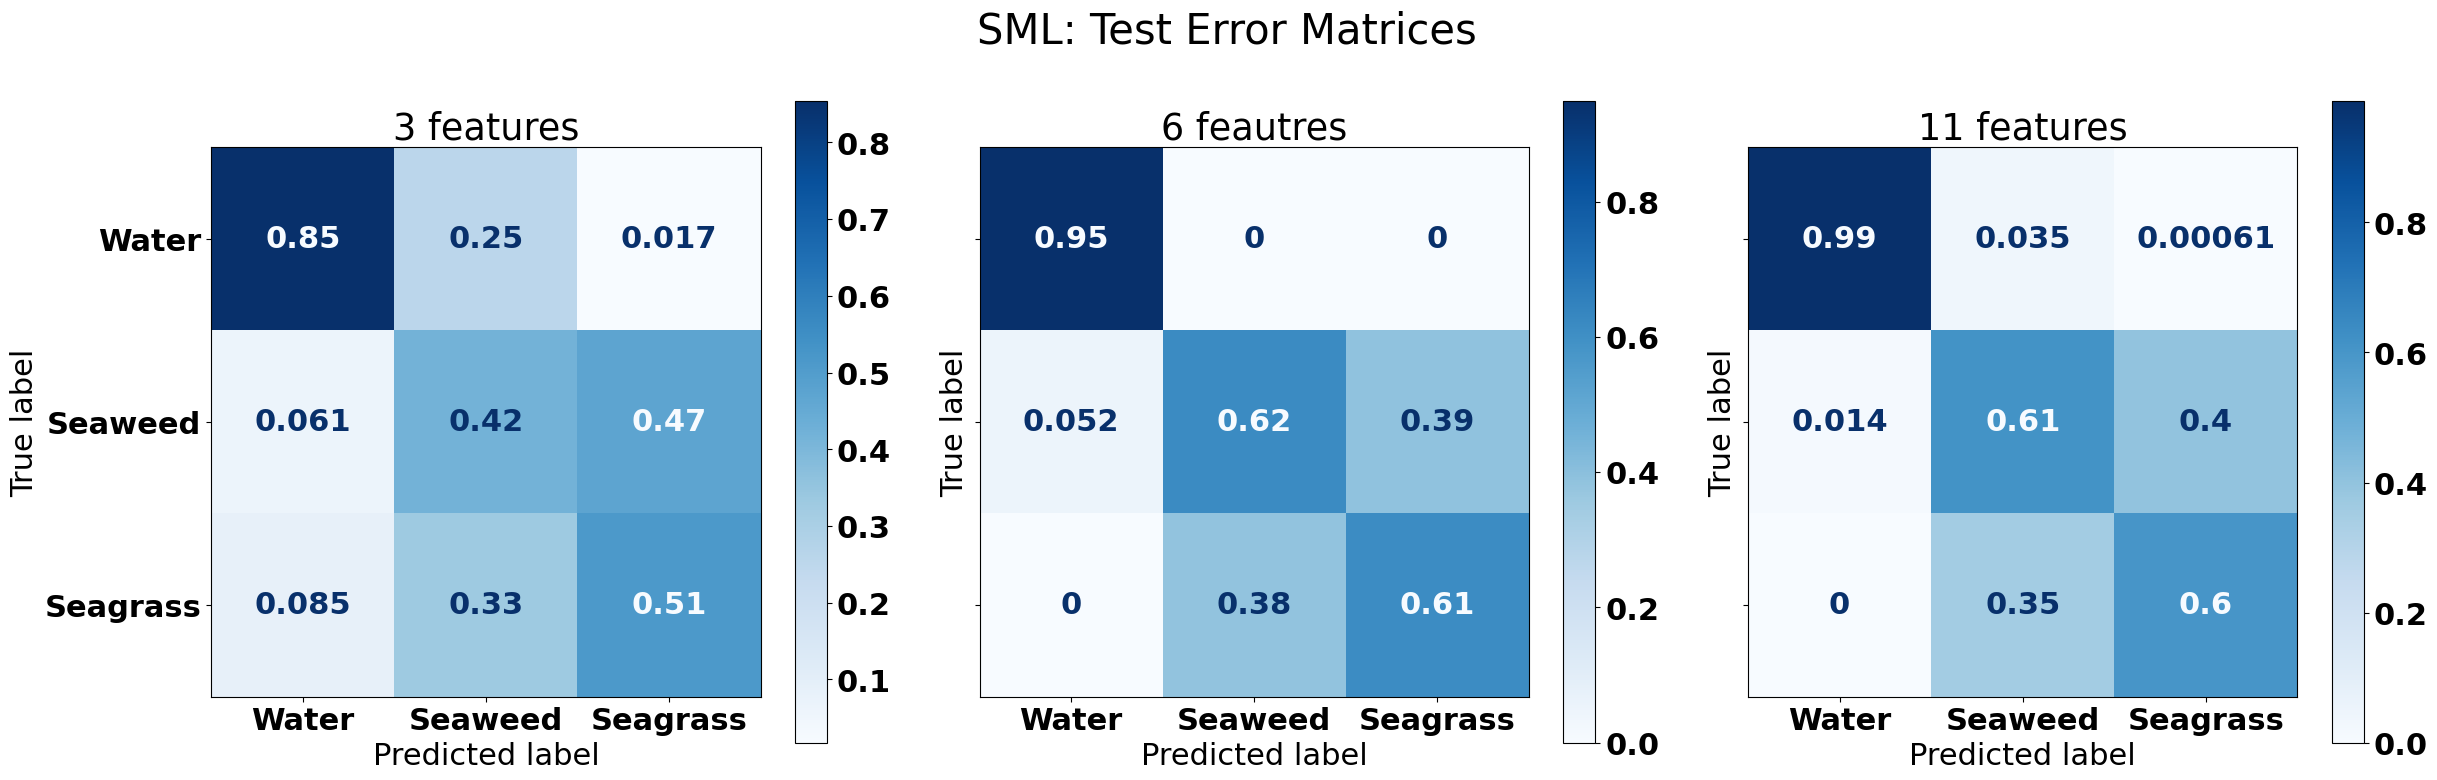

In [ ]:
# Plot confusion matrices next to each other 
# Source code: https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix. Accessed 21.03.23
font_dict = {'fontsize': 25,
            'fontweight':25}

font = {
    'weight' : 'bold',
    'size'   : 22}

fig, ax = plt.subplots(1, 3, figsize=(25,8), sharex = True, sharey = True)
fig.suptitle('SML: Test Error Matrices', fontsize=30)
ax[0].set_title("3 features")
ax[1].set_title("6 feautres")
ax[2].set_title("11 features")

metrics.ConfusionMatrixDisplay(
confusion_matrix = cm3t/cm3t.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[0], cmap='Blues') # values_format= '2g'

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm6t/cm6t.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass'] ).plot(ax=ax[1], cmap='Blues')

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm11t/cm11t.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[2], cmap='Blues')
#values_formatstr
plt.rc('font', **font)
plt.tight_layout()  
plt.show()

In [ ]:
def conf_matrix(cm):
  categories = ['Water', 'Seweed', 'Seagrass']
  # source code: https://onestopdataanalysis.com/confusion-matrix-python/. Accessed 17.03.23
  fig, ax = plt.subplots(figsize=(5,5))
  # source code: https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix. Accessed 18.03.23
  ax = sns.heatmap(cm/cm.astype(float).sum(axis=0), linewidths=1, annot=True, ax=ax, fmt='.2%', cmap='Blues')
  ax.set_xticklabels(categories)
  ax.set_yticklabels(categories)

#conf_matrix(cm11t)

In [ ]:
cm3 = confusion_matrix(results3[3],results3[2])
cm6 = confusion_matrix(results6[3],results6[2])
cm11 = confusion_matrix(results11[3],results11[2])

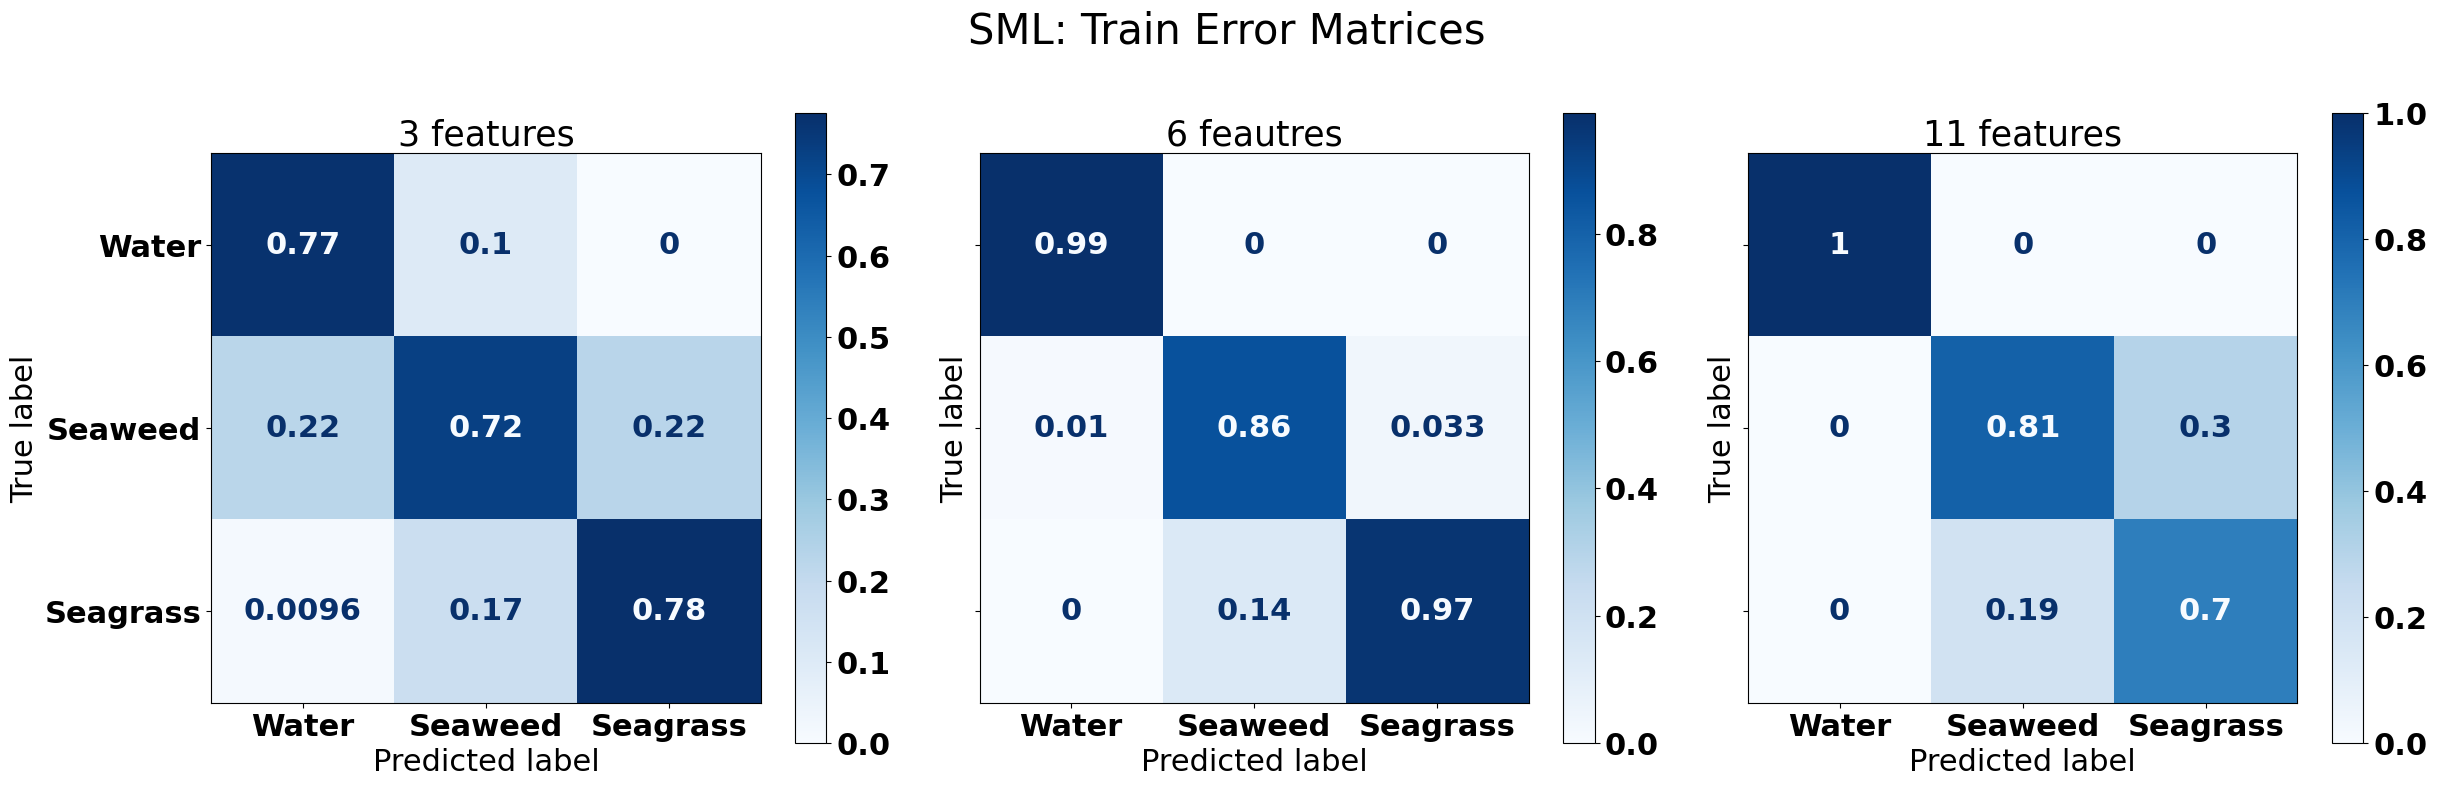

In [ ]:
# Plot confusion matrices next to each other 
# Source code: https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix. Accessed 21.03.23
font_dict = {'fontsize': 25,
            'fontweight':25}

font = {
    'weight' : 'bold',
    'size'   : 22}

fig, ax = plt.subplots(1, 3, figsize=(25,8), sharex = True, sharey = True)
fig.suptitle('SML: Train Error Matrices', fontsize=30)
ax[0].set_title("3 features", fontdict=font_dict)
ax[1].set_title("6 feautres", fontdict=font_dict)
ax[2].set_title("11 features", fontdict=font_dict)

metrics.ConfusionMatrixDisplay(
confusion_matrix = cm3/cm3.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[0], cmap='Blues') # values_format= '2g'

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm6/cm6.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass'] ).plot(ax=ax[1], cmap='Blues')

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm11/cm11.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[2], cmap='Blues')
#values_formatstr
plt.rc('font', **font)
plt.tight_layout()  
plt.show()

# Tau coefficient: Test data

In [ ]:
pra3t = results3t[0] # Overall accuracy
pra6t = results6t[0] # Overall accuracy
pra11t = results11t[0] # Overall accuracy

def tau(pra_x):
  pre = np.float64(0.33333)    #chance from three classes are 0.3333  
  tau =  (pra_x - pre)/(1-pre)
  return print(f'tau = {tau:.3f}')

print(f' SML with 3 features has:')
tau3t = tau(pra3t)
print(f' SML with 6 features has:')
tau6t = tau(pra6t)
print(f' SML with 11 features has:')
tau11t = tau(pra11t)

 SML with 3 features has:
tau = 0.380
 SML with 6 features has:
tau = 0.598
 SML with 11 features has:
tau = 0.594


# Local Rf training 
source code: https://geemap.org/notebooks/46_local_rf_training/#convert-a-sklearn-classifier-object-to-a-list-of-strings. Accessed: 13.02.23

In [ ]:
def ee_classifier(data):
  y = data.iloc[:,-1]  # Get class lables
  label = y.name       # Get the name of class label
  X = data.drop(label, axis = 1) # Get only feaures 

  # Standardize the data 
  X_std = StandardScaler().fit_transform(X)
  # Training dataset set to 80 %
  X_train, X_rem, y_train, y_rem = train_test_split(X_std, y, train_size=0.8, random_state=42)
  # Validation and test dataset set to 10% each
  X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)


  rfc=RandomForestClassifier(random_state=42)

  param_grid = {'n_estimators':[int(x) for x in np.linspace(start=10, stop = 30, num = 5)],
              'max_features': ['sqrt', 'log2', None],
              'max_depth':[2,4,10],
              'min_samples_split': [2,5],
              'min_samples_leaf':[1,2],
              'bootstrap':[True, False],
              }

  CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv= 10, refit=True)
  CV_rfc.fit(X_train, y_train)
  # Source code: https://datascience.stackexchange.com/questions/21877/how-to-use-the-output-of-gridsearch. Accessed 13.02.23
  optimised_random_forest = CV_rfc.best_estimator_  
  features = list(data.columns)
  feature_names = features[:-1]
  trees = ml.rf_to_strings(optimised_random_forest, feature_names)

 # create a ee classifier to use with ee objects from the trees
  ee_classifier = ml.strings_to_classifier(trees)
  classified = s2_deglint_masked.select(feature_names).classify(ee_classifier)
  return classified
  

In [ ]:
Image3 = ee_classifier(pb3_test)
Image6 = ee_classifier(pb6_test)
remap3 = Image3.remap([1,2,3],[0,1,2])
remap6 = Image6.remap([1,2,3],[0,1,2])

In [ ]:
obia_train.columns

Index(['B2', 'B3', 'B4', 'B8', 'NDVI', 'area', 'bathymetry', 'clusters',
       'height', 'perimeter', 'width', 'Cover'],
      dtype='object')

In [ ]:
objectPropertiesImage.bandNames()

In [ ]:
Image11 = ee_classifier(obia_train)
remap11 = Image11.remap([1,2,3],[0,1,2])

In [ ]:
Image3test = ee_classifier(pb3_test)
Image6test = ee_classifier(pb6_test)
remap3t = Image3test.remap([1,2,3],[0,1,2])
remap6t = Image3test.remap([1,2,3],[0,1,2])

In [ ]:
Image11test = ee_classifier(data11t_ndup)
remap11t = Image11test.remap([1,2,3],[0,1,2])

# Add ground truth data geometry of seagrass, seaweed, and water

In [ ]:
# Add ground truth data geometry of seagrass, seaweed, and water
# Must upload to google colabs for each new runtime...
shp_path_SW = '/content/Coastal_Marine_Geology.shp'
seaweed_shp = geemap.shp_to_ee(shp_path_SW)
'''
shp_path_SG = '/content/MaineDEP_Seagrass_2021_(South_Coast_-_Elliot_to_Cape_Elizabeth).shp'
seagrass_shp = geemap.shp_to_ee(shp_path_SG)

# Drew rectangles to represent water, than downloaded them locally
# geemap.ee_to_shp(water, filename='/content/water.shp')
shp_path_water_test = '/content/water_test.shp'
water_test_shp = geemap.shp_to_ee(shp_path_water_test)

shp_path_roi_test = '/content/roi_test.shp'
roi_test = geemap.shp_to_ee(shp_path_roi_test)

shp_path_SG22 = '/content/MaineDEP_Seagrass_2022_(Casco_Bay_Only).shp'
seagrass_shp22 = geemap.shp_to_ee(shp_path_SG22)
'''
shp_path_SG18 = '/content/MaineDEP_-_Eelgrass_2018_(Casco_Bay_Only).shp'
seagrass_shp18 = geemap.shp_to_ee(shp_path_SG18)



# Display results of map 

In [ ]:
!pip install mss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached mss-8.0.2-py3-none-any.whl (73 kB)


In [ ]:
# display results
Map = geemap.Map()
Map.set_center(-69.740859, 43.544235, zoom=10)
#S2_deglint = deglint(s2_composite_min) 
#vis_params = {"bands": [ 'B2', 'B3', 'B4'], "min": 0, "max": 1500, "gamma": 1.5}
#Map.addLayer(s2_composite_min, vis_params, 'Sent-2 min')
# Show image in map
vis_params_deglint = {"bands": [ 'B2', 'B3','B4'], "min": 0, "max": 1500, 'gamma':1.5}
Map.addLayer(s2_composite_min, vis_params, 'Sent-2 min')
Map.addLayer(S2_deglint, vis_params_deglint, 'Deglinted image')

Map.addLayer(
    remap3t,
    {"min": 0, "max": 2, "palette":['deepskyblue', 'chocolate', 'forestgreen']},
    'remapped 3 Casco Bay')

Map.addLayer(
    remap6t,
    {"min": 0, "max": 2, "palette": ['deepskyblue', 'chocolate', 'forestgreen']},
    'remapped 6 Casco Bay')
'''
Map.addLayer(
    remap11,
    {"min": 0, "max": 2, "palette": ['deepskyblue', 'chocolate', 'forestgreen']},
    'remapped 11 tain')
'''
# Source code: https://github.com/giswqs/earthengine-py-examples/blob/master/Visualization/rendering_categorical_maps.py. Accessed: 15.03.23

#Map.addLayer(
#    Image11test,
#    {"min": 1, "max": 3, "palette": ['#7b3e00', '1c5f2c', '#0d98ba']},
#    'RF 11 features train',
#)
vis_params_sw = {'color':'#7b3e00'}
vis_params_sg = {'color':'1c5f2c'} 
vis_params_water = {'color':'#0d98ba'}  

Map.addLayer(seagrass_shp, vis_params_sg, 'seagrass from 2021')
#Map.addLayer(seagrass_shp, vis_params_sg, 'seagrass from 2018')
#Map.addLayer(seagrass_shp22, vis_params_sg, 'seagrass from 2022')
Map.addLayer(seaweed_shp, vis_params_sw, 'seaweed')
#Map.addLayer(water_shp, vis_params_water, 'water')
Map.addLayer(water_test_shp, vis_params_water, 'water')
#Map.addLayer(roi_train, {}, 'ROI')')

# display results
#vis_params_sw = {'color':'#7b3e00'}
#vis_params_sg = {'color':'1c5f2c'} 
#vis_params_water = {'color':'#0d98ba'}  
Map.addLayer(S2_masked, {'palette': ['black']} , 'S2 Land Mask')
Map

Map(center=[43.544235, -69.740859], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [ ]:
#geemap.update_package()

Unzipping geemap-master.zip ...
Data downloaded to: /root/Downloads/geemap-master

Please comment out 'geemap.update_package()' and restart the kernel to take effect:
Jupyter menu -> Kernel -> Restart & Clear Output


In [ ]:
download_dir = os.path.join(os.path.expanduser('~'), 'Nedlastinger')
png_file = os.path.join(download_dir, 'my_map.png')
Map.to_image(filename=png_file, monitor=1)

$DISPLAY not set.


# Unsupervised classification algorithm

In [ ]:
def unsupervised(data, algorithm = " ", eps=0.3, min_sample=3 ):
  y = data.iloc[:,-1]  # Get class lables
  y = y.replace([1,2,3],[0,1,2])
  label = y.name       # Get the name of class label
  X = data.drop(label, axis = 1) # Get only feaures 
  #y=y.astype('int')  # y was firstly of type 'object', needs to be an integer for sklearn to recognize it.
  X_std = StandardScaler().fit_transform(X)
  
  pca = PCA(n_components = 3)
  X_pca = pca.fit(X_std)
  X_trans_pca = pca.transform(X_std)

  if algorithm == 'kMeans':
    km = KMeans(n_clusters=3, max_iter=100, random_state=40, n_init=10)
    km.fit(X_trans_pca)
    y_pred = km.labels_
  elif algorithm == 'DBSCAN':
    db = DBSCAN(eps=eps, min_samples = min_sample, metric='euclidean')
    db_fit = db.fit_predict(X_trans_pca)
    y_pred = db.labels_
  else: 
    print('Error: Missing one positional argument. Insert algorithm name \n "kMeans" or "DBSCAN". \n If this is not the error, you have not inserted the data')
  return accuracy_score(y, y_pred), len(X.columns), y_pred, y, X_trans_pca, label
# the scikit-learn algorithm with n_init=10 runs the k-means 10 times and returns the r
# one that gave the lowest SSE
# Source: https://realpython.com/k-means-clustering-python/. Accessed 20.03.23


In [ ]:
# Source code: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/. Accessed 10.04.23

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(pb6_train)


In [ ]:
data_rescaled[:4]

array([[0.26285126, 0.22933301, 0.15260926, 0.02811245, 0.36227376,
        0.07425743, 0.        ],
       [0.47661445, 0.55454656, 0.22171975, 0.18072289, 0.68658088,
        0.82673267, 1.        ],
       [0.42130621, 0.54634942, 0.30819533, 0.16064257, 0.58588235,
        0.82673267, 1.        ],
       [0.36066349, 0.1903159 , 0.08546998, 0.02811245, 0.50892857,
        0.01980198, 0.        ]])

In [ ]:
pca = PCA().fit(data_rescaled)

xi = np.arange(1, 8, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

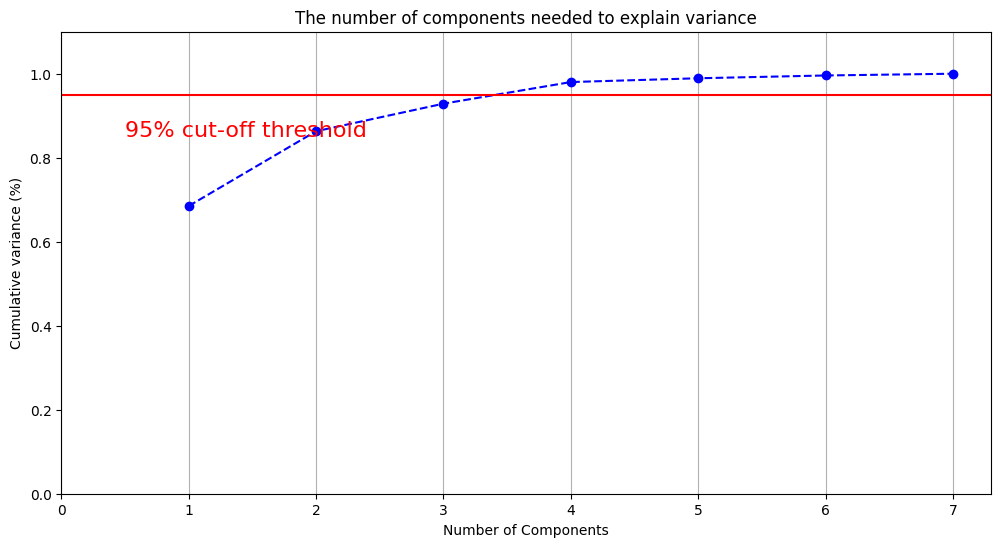

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 8, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    X_trans_pca = pca.transform(data_rescaled)
    kmeanModel.fit(X_trans_pca)
    distortions.append(kmeanModel.inertia_)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

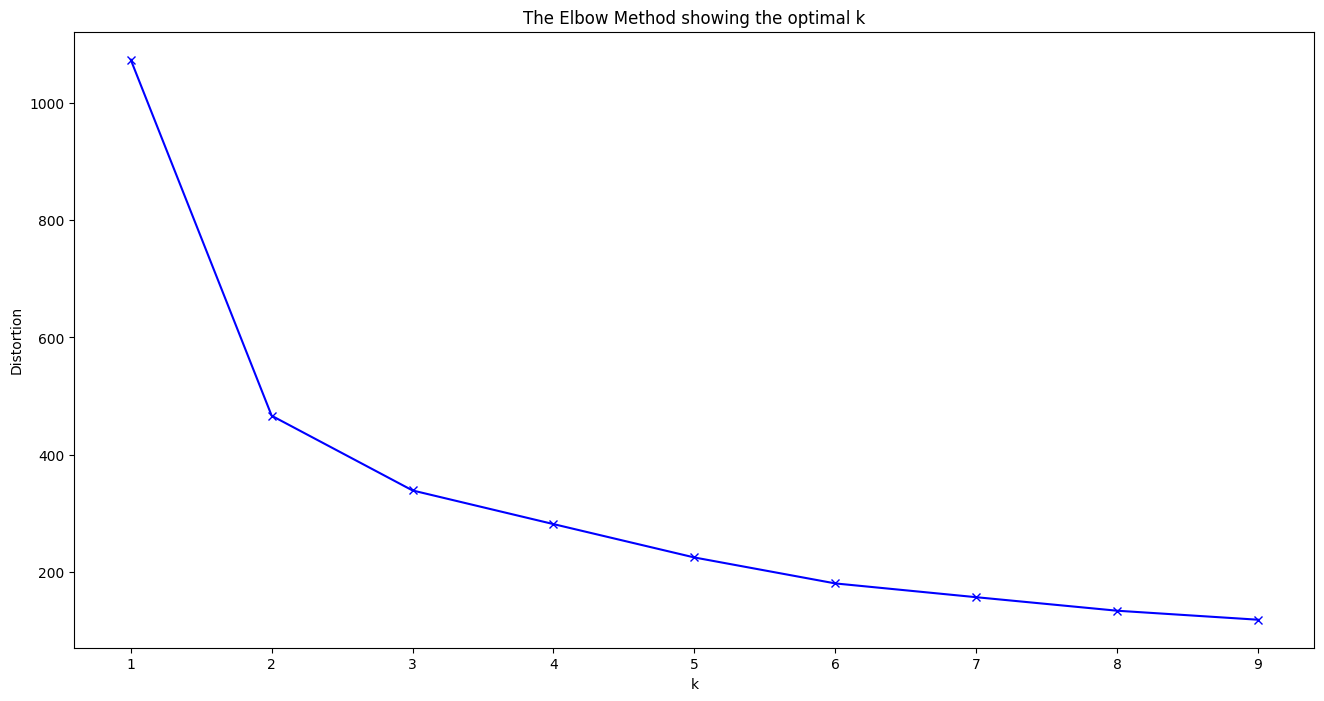

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Training -> Unsupervised accuracy metrices: kMeans

In [ ]:
results3km = unsupervised(pb3_train,'kMeans')
results6km = unsupervised(pb6_train,'kMeans')
results11km = unsupervised(obia_train,'kMeans')

###############################
# Results from 3 features 
print(f'{results3km[0]*100:,.2f} where accuratly classified given 3 features: Training kMeans')
kmeans_silhouette3 = silhouette_score(results3km[4],results3km[2]).round(2)
print('kmeans silhouette: ', kmeans_silhouette3)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(results3km[3], results3km[2]))
print('-----------------------------------------------------------------')
print(f'{results6km[0]*100:,.2f} where accuratly classified given 6 features: Training kMeans')
kmeans_silhouette6 = silhouette_score(results6km[4],results6km[2]).round(2)
print('kmeans silhouette: ', kmeans_silhouette6)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(results6km[3], results6km[2]))
print('-----------------------------------------------------------------')
print(f'{results11km[0]*100:,.2f} where accuratly classified given 11 features: Training kMeans ')
kmeans_silhouette11 = silhouette_score(results11km[4],results11km[2]).round(2)
print('kmeans silhouette: ', kmeans_silhouette11)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(results11km[3], results11km[2]))
print('-----------------------------------------------------------------')


50.23 where accuratly classified given 3 features: Training kMeans
kmeans silhouette:  0.48
Adjusted Rand Index: 0.273
-----------------------------------------------------------------
15.34 where accuratly classified given 6 features: Training kMeans
kmeans silhouette:  0.39
Adjusted Rand Index: 0.472
-----------------------------------------------------------------
41.19 where accuratly classified given 11 features: Training kMeans 
kmeans silhouette:  0.38
Adjusted Rand Index: 0.032
-----------------------------------------------------------------


# Test -> Unsupervised accuracy metrices: kMeans

In [ ]:
results3km = unsupervised(pb3_test,'kMeans')
results6km = unsupervised(pb6_test,'kMeans')
results11km = unsupervised(obia_test,'kMeans')

###############################
# Results from 3 features 
print(f'{results3km[0]*100:,.2f} where accuratly classified given 3 features: Test kMeans')
kmeans_silhouette3 = silhouette_score(results3km[4],results3km[2]).round(2)
print('kmeans silhouette: ', kmeans_silhouette3)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(results3km[3], results3km[2]))
print('-----------------------------------------------------------------')
print(f'{results6km[0]*100:,.2f} where accuratly classified given 6 features: Test kMeans')
kmeans_silhouette6 = silhouette_score(results6km[4],results6km[2]).round(2)
print('kmeans silhouette: ', kmeans_silhouette6)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(results6km[3], results6km[2]))
print('-----------------------------------------------------------------')
print(f'{results11km[0]*100:,.2f} where accuratly classified given 11 features: Test kMeans ')
kmeans_silhouette11 = silhouette_score(results11km[4],results11km[2]).round(2)
print('kmeans silhouette: ', kmeans_silhouette11)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(results11km[3], results11km[2]))
print('-----------------------------------------------------------------')


18.84 where accuratly classified given 3 features: Test kMeans
kmeans silhouette:  0.53
Adjusted Rand Index: 0.096
-----------------------------------------------------------------
30.80 where accuratly classified given 6 features: Test kMeans
kmeans silhouette:  0.39
Adjusted Rand Index: 0.290
-----------------------------------------------------------------
35.07 where accuratly classified given 11 features: Test kMeans 
kmeans silhouette:  0.43
Adjusted Rand Index: 0.129
-----------------------------------------------------------------


# UML

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


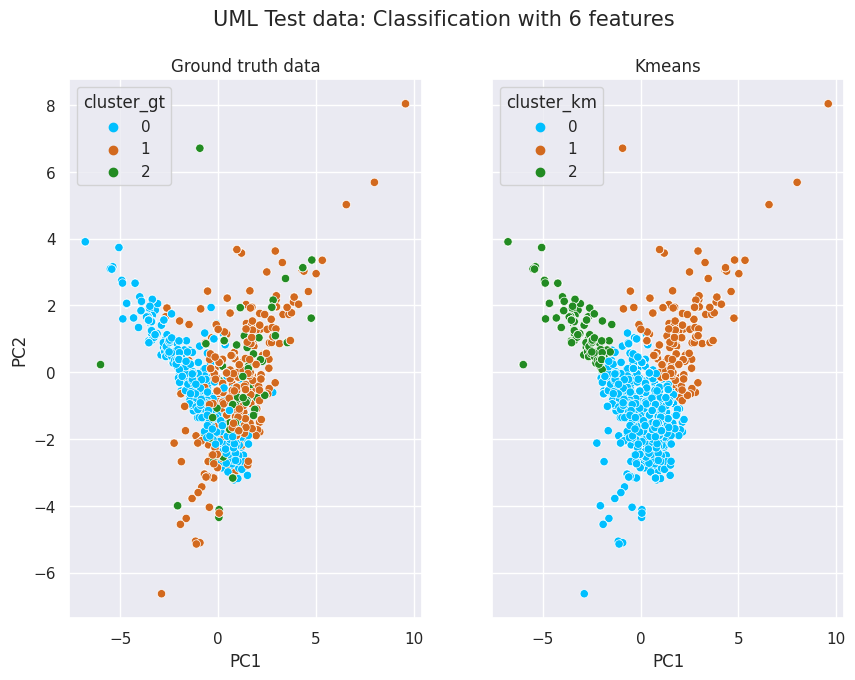

In [ ]:
def UML_visuals(data):
  y = data.iloc[:,-1]  # Get class lables
  y = y.replace([1,2,3],[0,1,2])
  label = y.name       # Get the name of class label
  X = data.drop(label, axis = 1) # Get only feaures

  # Source code: https://stackoverflow.com/questions/66204637/visualizing-clusters-result-using-pca-python. Accessed 27.03.2023
  Sc = StandardScaler()  # Alternativley use:  MinMaxScaler() when data is not normally distributed (for the training data)
  X = Sc.fit_transform(X)
  pca = PCA(3) 
  pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2', 'PC3']) 

  kmeans =KMeans(n_clusters=3).fit(X)
  # Classified clusters 
  pca_data['cluster_km'] = pd.Categorical(kmeans.labels_)

  # Ground truth data 
  pca_data['cluster_gt'] = pd.Categorical(y)

  #set seaborn plotting aesthetics as default
  sns.set()

  #define plotting region (1 rows, 2 columns)
  fig, axes = plt.subplots(1, 2, sharey = True, figsize=(10, 7))

  fig.suptitle('UML Test data: Classification with 6 features', fontsize=15)
  palette = {0: "deepskyblue", 1: "chocolate", 2: "forestgreen"}

  sns.scatterplot(data=pca_data, x="PC1",y="PC2",hue="cluster_gt", palette = palette, ax=axes[0]).set(title='Ground truth data')
  sns.scatterplot(data=pca_data, x="PC1",y="PC2",hue="cluster_km", palette = palette ,ax=axes[1]).set(title='Kmeans')

  return plt.show()

UML_visuals(obia_test)

#5-fold CV: Kmeans training

In [ ]:
data3 = pb3_train.sample(frac=1, random_state=1) # sample rows without replacement
data6 = pb6_train.sample(frac=1, random_state=1) # sample rows without replacement
data11 = obia_train.sample(frac=1, random_state=1) # sample rows without replacement

################################################################
# Samples (s)
s = [int(x) for x in np.linspace(start=144, stop = 720, num = 5)], # List comprehension
data31 = data3[:s[0][0]]
data32 = data3[s[0][0]:s[0][1]]
data33 = data3[s[0][1]:s[0][2]]
data34 = data3[s[0][2]:s[0][3]]
data35 = data3[s[0][3]:]

CV_UML3 = [data31, data32, data33, data34, data35]
accurarcyCV3 = []

################################################################
data61 = data6[:s[0][0]]
data62 = data6[s[0][0]:s[0][1]]
data63 = data6[s[0][1]:s[0][2]]
data64 = data6[s[0][2]:s[0][3]]
data65 = data6[s[0][3]:]

CV_UML6 = [data61, data62, data63, data64, data65]
accurarcyCV6 = []

###############################################################3
data111 = data11[:s[0][0]]
data112 = data11[s[0][0]:s[0][1]]
data113 = data11[s[0][1]:s[0][2]]
data114 = data11[s[0][2]:s[0][3]]
data115 = data11[s[0][3]:]

CV_UML11 = [data111, data112, data113, data114, data115]
accurarcyCV11 = []
################################################################
for dataset in CV_UML3: 
  result = unsupervised(dataset, algorithm = "kMeans")
  accurarcyCV3.append(result[0])

for dataset in CV_UML6: 
  result = unsupervised(dataset, algorithm = "kMeans")
  accurarcyCV6.append(result[0])

for dataset in CV_UML11: 
  result = unsupervised(dataset, algorithm = "kMeans")
  accurarcyCV11.append(result[0])

AC_array3 = np.array(accurarcyCV3)
AC_array6 = np.array(accurarcyCV6)
AC_array11 = np.array(accurarcyCV11)

print(f'{AC_array3.mean()*100:,.2f} is the average accuracy for 5 datasets (with 144 samles each) given 3 features: Training Kmeans')
print(f'{AC_array6.mean()*100:,.2f} is the average accuracy for 5 datasets (with 144 samles each) given 6 features: Training Kmeans')
print(f'{AC_array11.mean()*100:,.2f} is the average accuracy for 5 datasets (with 144 samles each) given 11 features: Training Kmeans')


41.60 is the average accuracy for 5 datasets (with 144 samles each) given 3 features: Training Kmeans
35.87 is the average accuracy for 5 datasets (with 144 samles each) given 6 features: Training Kmeans
39.71 is the average accuracy for 5 datasets (with 144 samles each) given 11 features: Training Kmeans


<ipython-input-12-5240a0de27f9>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['3 features', '6 features',


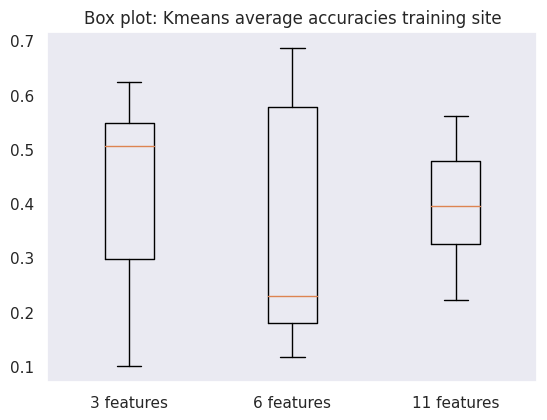

In [ ]:
UML_km_AC_train = [AC_array3, AC_array6, AC_array11]

fig= plt.figure(figsize =(7, 5))

# Creating axes instance
ax1 = fig.add_axes([0,0, 0.7,0.7])
# x-axis labels
ax1.set_xticklabels(['3 features', '6 features',
                    '11 features'])
# Adding title
plt.title("Box plot: Kmeans average accuracies training site")
# Creating plot
bp = ax1.boxplot(UML_km_AC_train)
plt.grid()

# Confusion matrix of UML: training error (Kmeans)

In [ ]:
results3km = unsupervised(pb3_train,'kMeans')
results6km = unsupervised(pb6_train,'kMeans')
results11km = unsupervised(obia_train,'kMeans')

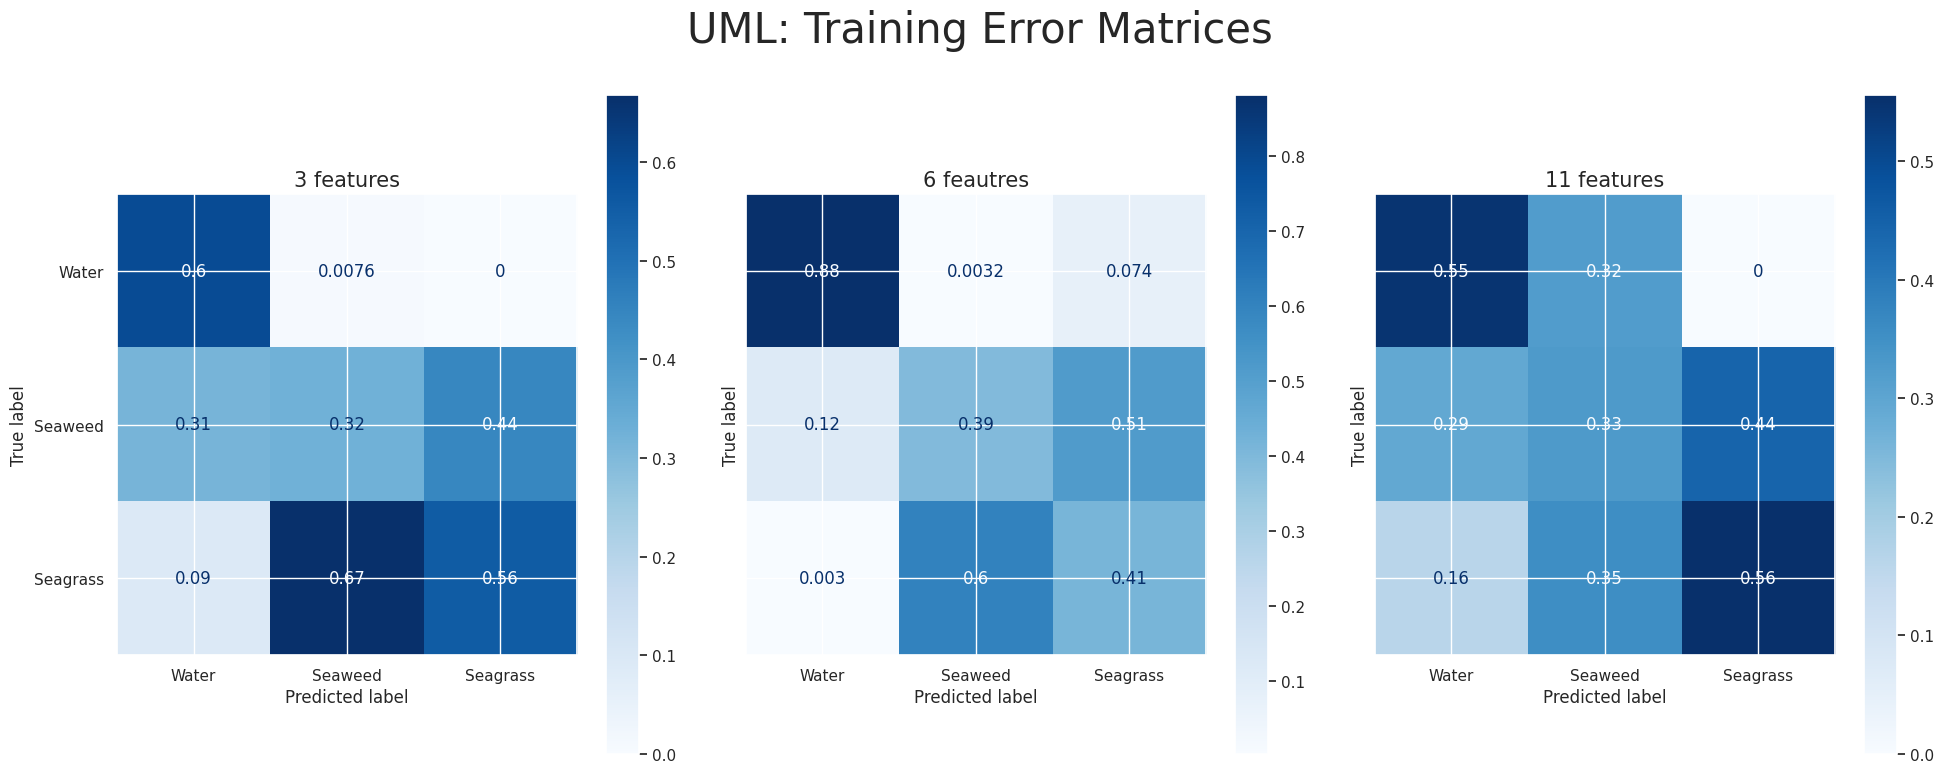

In [ ]:
cm3km = confusion_matrix(results3km[3],results3km[2])
cm6km = confusion_matrix(results6km[3],results6km[2])
cm11km = confusion_matrix(results11km[3],results11km[2])

font = {
    'weight' : 'bold',
    'size'   : 20}

fig, ax = plt.subplots(1, 3, figsize=(20,8), sharex = True, sharey = True)

font_dict = {'fontsize': 15,
            'fontweight':25}

ax[0].set_title("3 features", fontdict=font_dict)
ax[1].set_title("6 feautres", fontdict=font_dict)
ax[2].set_title("11 features", fontdict=font_dict)
fig.suptitle('UML: Training Error Matrices', fontsize=30)

metrics.ConfusionMatrixDisplay(
confusion_matrix = cm3km/cm3km.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[0], cmap='Blues') # values_format= '2g'

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm6km/cm6km.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass'] ).plot(ax=ax[1], cmap='Blues')

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm11km/cm11km.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[2], cmap='Blues')
#values_formatstr
plt.rc('font', **font)
plt.tight_layout()  
plt.show()

In [ ]:
data3 = pb3_test.sample(frac=1, random_state=1) # sample rows without replacement
data6 = pb6_test.sample(frac=1, random_state=1) # sample rows without replacement
data11 = obia_test.sample(frac=1, random_state=1) # sample rows without replacement

################################################################
# Samples (s)
s = [int(x) for x in np.linspace(start=55, stop = 276, num = 5)], # List comprehension
data31 = data3[:s[0][0]]
data32 = data3[s[0][0]:s[0][1]]
data33 = data3[s[0][1]:s[0][2]]
data34 = data3[s[0][2]:s[0][3]]
data35 = data3[s[0][3]:]

CV_UML3 = [data31, data32, data33, data34, data35]
accurarcyCV3 = []

################################################################
data61 = data6[:s[0][0]]
data62 = data6[s[0][0]:s[0][1]]
data63 = data6[s[0][1]:s[0][2]]
data64 = data6[s[0][2]:s[0][3]]
data65 = data6[s[0][3]:]

CV_UML6 = [data61, data62, data63, data64, data65]
accurarcyCV6 = []

###############################################################3
data111 = data11[:s[0][0]]
data112 = data11[s[0][0]:s[0][1]]
data113 = data11[s[0][1]:s[0][2]]
data114 = data11[s[0][2]:s[0][3]]
data115 = data11[s[0][3]:]

CV_UML11 = [data111, data112, data113, data114, data115]
accurarcyCV11 = []
################################################################
for dataset in CV_UML3: 
  result = unsupervised(dataset, algorithm = "kMeans")
  accurarcyCV3.append(result[0])

for dataset in CV_UML6: 
  result = unsupervised(dataset, algorithm = "kMeans")
  accurarcyCV6.append(result[0])

for dataset in CV_UML11: 
  result = unsupervised(dataset, algorithm = "kMeans")
  accurarcyCV11.append(result[0])

AC_array3t = np.array(accurarcyCV3)
AC_array6t = np.array(accurarcyCV6)
AC_array11t = np.array(accurarcyCV11)

print(f'{AC_array3t.mean()*100:,.2f} is the average accuracy for 5 datasets (with 144 samles each) given 3 features: Test Kmeans')
print(f'{AC_array6t.mean()*100:,.2f} is the average accuracy for 5 datasets (with 144 samles each) given 6 features: Test Kmeans')
print(f'{AC_array11t.mean()*100:,.2f} is the average accuracy for 5 datasets (with 144 samles each) given 11 features: Test Kmeans')


25.39 is the average accuracy for 5 datasets (with 144 samles each) given 3 features: Test Kmeans
28.69 is the average accuracy for 5 datasets (with 144 samles each) given 6 features: Test Kmeans
46.97 is the average accuracy for 5 datasets (with 144 samles each) given 11 features: Test Kmeans


<ipython-input-16-f6aacc14c7d6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['3 features', '6 features',


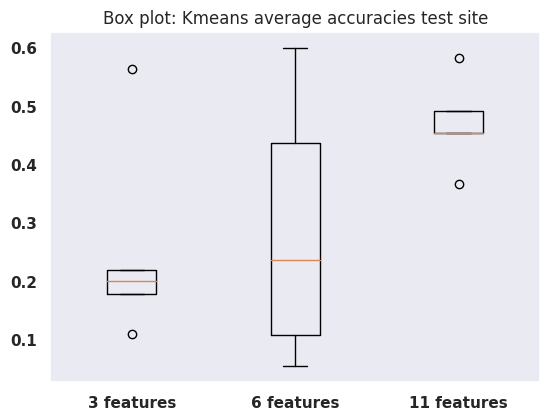

In [ ]:
UML_km_AC_test = [AC_array3t, AC_array6t, AC_array11t]

fig= plt.figure(figsize =(7, 5))

# Creating axes instance
ax1 = fig.add_axes([0,0, 0.7,0.7])
# x-axis labels
ax1.set_xticklabels(['3 features', '6 features',
                    '11 features'])
# Adding title
plt.title("Box plot: Kmeans average accuracies test site")
# Creating plot
bp = ax1.boxplot(UML_km_AC_test)
plt.grid()

<ipython-input-17-50ed8a2ed0b8>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['3', '6',
<ipython-input-17-50ed8a2ed0b8>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['3', '6',


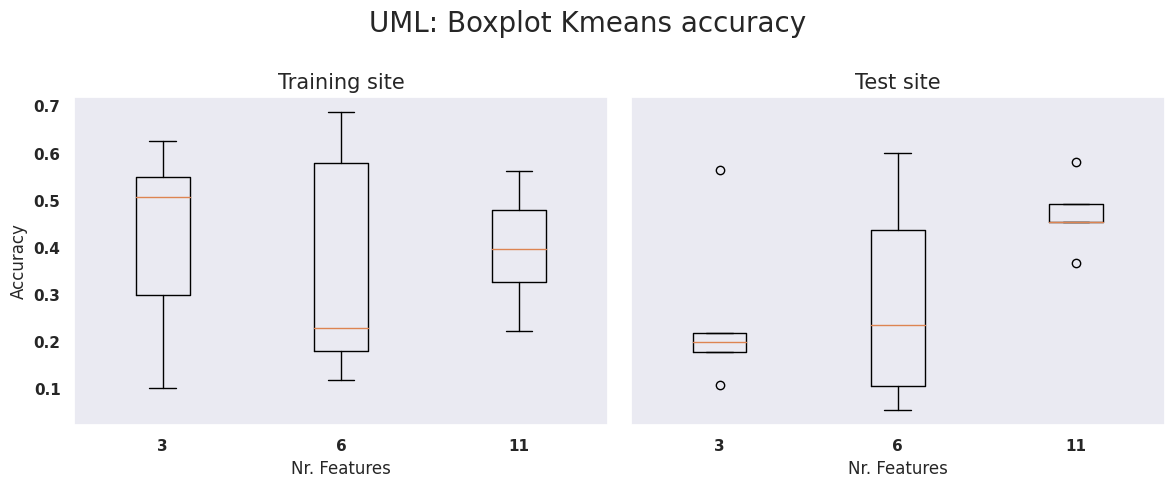

In [ ]:
font = {
    'weight' : 'bold',
    'size'   : 15}

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), sharex = False, sharey = True)
font_dict = {'fontsize': 15,
            'fontweight':15}

ax1.set_title("Training site", fontdict=font_dict)
ax1.set_xticklabels(['3', '6',
                    '11'])
ax1.set_xlabel('Nr. Features')
ax1.set_ylabel('Accuracy')

ax2.set_title("Test site", fontdict=font_dict)
ax2.set_xticklabels(['3', '6',
                    '11'])
ax2.set_xlabel('Nr. Features')
fig.suptitle('UML: Boxplot Kmeans accuracy', fontsize=20)
bp1 = ax1.boxplot(UML_km_AC_train)
bp2 = ax2.boxplot(UML_km_AC_test)


plt.rc('font', **font)
ax1.grid()
ax2.grid()
plt.tight_layout()  
plt.show()

In [ ]:
results3km = unsupervised(pb3_test,'kMeans')
results6km = unsupervised(pb6_test,'kMeans')
results11km = unsupervised(obia_test,'kMeans')

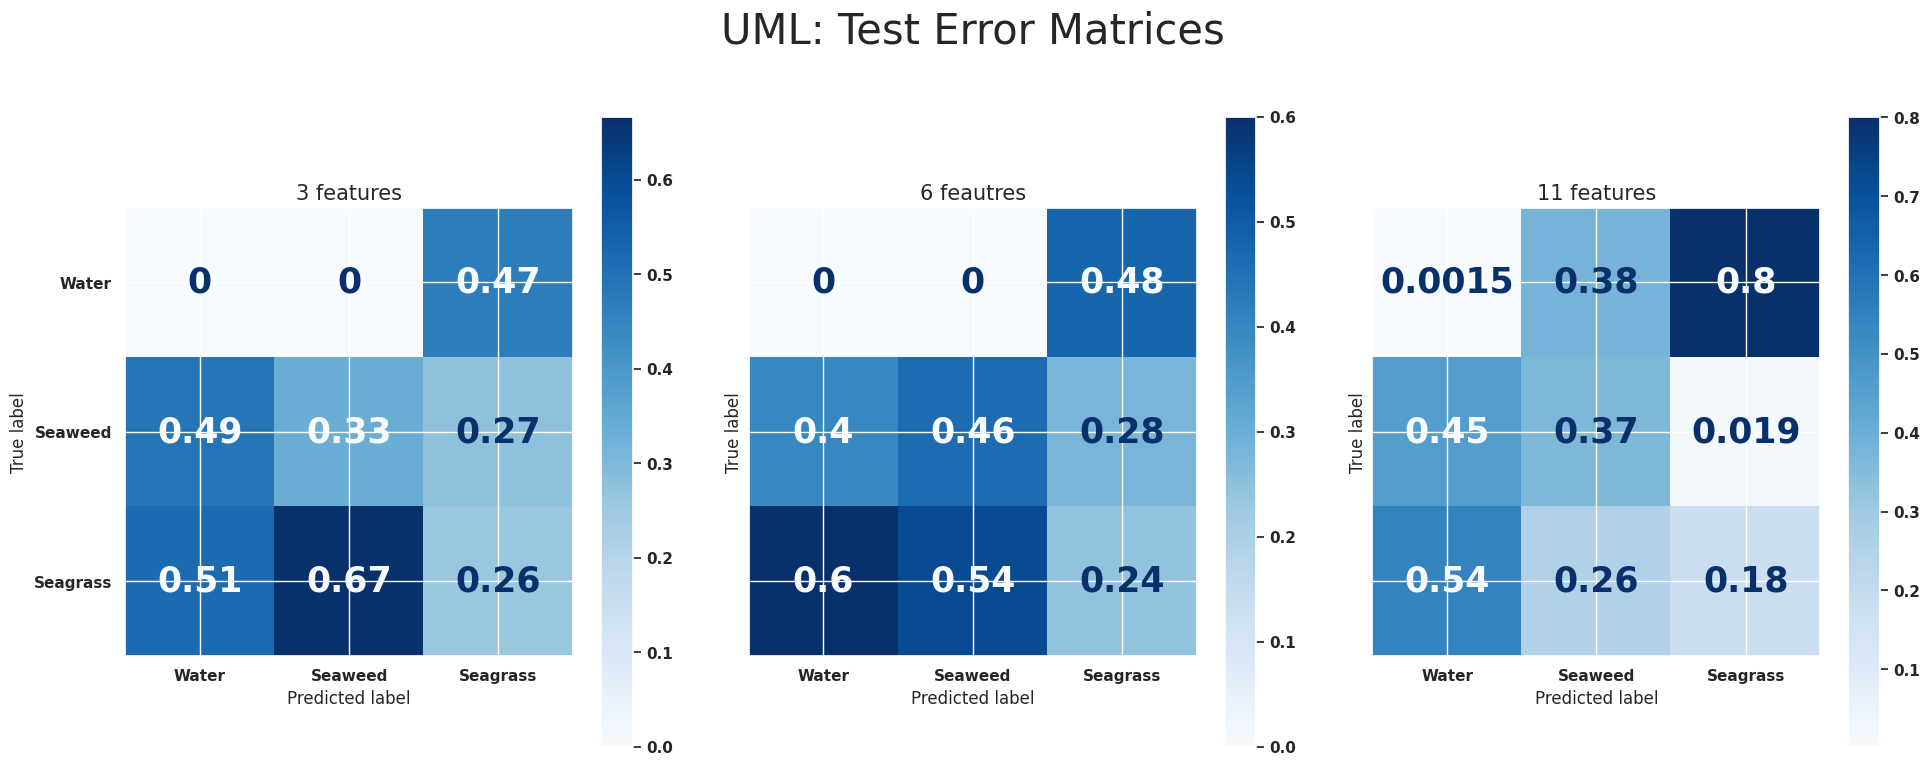

In [ ]:
cm3km = confusion_matrix(results3km[3],results3km[2])
cm6km = confusion_matrix(results6km[3],results6km[2])
cm11km = confusion_matrix(results11km[3],results11km[2])

font = {
    'weight' : 'bold',
    'size'   : 25}

fig, ax = plt.subplots(1, 3, figsize=(20,8), sharex = True, sharey = True)

font_dict = {'fontsize': 15,
            'fontweight':15}

ax[0].set_title("3 features", fontdict=font_dict)
ax[1].set_title("6 feautres", fontdict=font_dict)
ax[2].set_title("11 features", fontdict=font_dict)
fig.suptitle('UML: Test Error Matrices', fontsize=30)

metrics.ConfusionMatrixDisplay(
confusion_matrix = cm3km/cm3km.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[0], cmap='Blues') # values_format= '2g'

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm6km/cm6km.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass'] ).plot(ax=ax[1], cmap='Blues')

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm11km/cm11km.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[2], cmap='Blues')
#values_formatstr
plt.rc('font', **font)
plt.tight_layout()  
plt.show()

# Visual SSL

In [ ]:
def ee_classifier_ss(data):
  y = data.iloc[:,-1]  # Get class lables
  label = y.name       # Get the name of class label
  X = data.drop(label, axis = 1) # Get only feaures 

  # Standardize the data 
  X_std = StandardScaler().fit_transform(X)

  # Firstly, the dataset is split into a unlabeled and a remaining datasets
  # X_unlabled is 80% of the total dataset
  X_unlabled, X_rem, y_unlabled, y_rem = train_test_split(X_std, y, train_size=0.8, random_state=42)

  # Then, the remaining data is split into a labeled and a test dataset. 
  # we have to define valid_size=0.5 (that is 50% of remaining data)
  # The labled and test datasets each conaints 10% of the samples from the total data 
  test_size = 0.5
  X_labeled, X_test, y_labeled, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=42, shuffle=True)

  # Create a training and validation data from the labled data
  X_train, X_valid, y_train, y_valid = train_test_split(X_labeled,y_labeled, test_size=0.5, random_state=42, shuffle=True)

  # Initialize classifier
  rfc=RandomForestClassifier(random_state=42)
  param_grid = {'n_estimators':[int(x) for x in np.linspace(start=10, stop = 30, num = 5)],
              'max_features': ['sqrt', 'log2', None],
              'max_depth':[2,4,10],
              'min_samples_split': [2,5],
              'min_samples_leaf':[1,2],
              'bootstrap':[True, False]}

  CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv= 5, refit=True)
  CV_rfc.fit(X_train, y_train)

  preds = CV_rfc.predict(X_unlabled)

  # Merge dataset containing the labels
  y_pseudo = np.append(preds, y_train)

  # Merge dataset containing samples 
  pseudo_data = np.append(X_unlabled, X_train, axis=0)

  rf = RandomForestClassifier(random_state=3)

  CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv= 5, refit=True)
  CV_rf.fit(pseudo_data, y_pseudo)

  # Source code: https://datascience.stackexchange.com/questions/21877/how-to-use-the-output-of-gridsearch. Accessed 13.02.23
  optimised_random_forest = CV_rf.best_estimator_  
  features = list(data.columns)
  feature_names = features[:-1]
  trees = ml.rf_to_strings(optimised_random_forest, feature_names)

 # create a ee classifier to use with ee objects from the trees
  ee_classifier = ml.strings_to_classifier(trees)
  classified = objectPropertiesImage.select(feature_names).classify(ee_classifier)
  return classified

In [ ]:
Image3ss = ee_classifier_ss(data3_ndup)
Image6ss = ee_classifier_ss(data7_ndup)
remap3ssl= Image3ss.remap([1,2,3],[0,1,2])
remap6ssl= Image6ss.remap([1,2,3],[0,1,2])
Image11ss = ee_classifier_ss(data11_ndup)

In [ ]:
Image11ss = ee_classifier_ss(data11_ndup)
remap11ssl= Image11ss.remap([1,2,3],[0,1,2])

In [ ]:
Image3sstest = ee_classifier_ss(data3t_ndup)
Image6sstest = ee_classifier_ss(data7t_ndup)
remap3sslt= Image3sstest.remap([1,2,3],[0,1,2])
remap6sslt= Image6sstest.remap([1,2,3],[0,1,2])
#Image11sstest = ee_classifier_ss(data11t_ndup)
#remap11sslt= Image11sstest.remap([1,2,3],[0,1,2])

In [ ]:
# display results
Map = geemap.Map()
Map.set_center(-69.740859, 43.544235, zoom=10)
#S2_deglint = deglint(s2_composite_min) 
#vis_params = {"bands": [ 'B2', 'B3', 'B4'], "min": 0, "max": 1500, "gamma": 1.5}
#Map.addLayer(s2_composite_min, vis_params, 'Sent-2 min')
# Show image in map
vis_params_deglint = {"bands": [ 'B2', 'B3','B4'], "min": 0, "max": 1500, 'gamma':1.5}
Map.addLayer(S2_deglint, vis_params_deglint, 'Deglinted image')

Map.addLayer(
    remap3ssl,
    {"min": 0, "max": 2, "palette":['deepskyblue', 'chocolate', 'forestgreen']},
    'remapped 3 train')

Map.addLayer(
    remap11ssl,
    {"min": 0, "max": 2, "palette": ['deepskyblue', 'chocolate', 'forestgreen']},
    'remapped 11 tain')
'''
Map.addLayer(
    remap11sslt,
    {"min": 0, "max": 2, "palette": ['deepskyblue', 'chocolate', 'forestgreen']},
    'remapped 11 tain')

'''
# Source code: https://github.com/giswqs/earthengine-py-examples/blob/master/Visualization/rendering_categorical_maps.py. Accessed: 15.03.23

vis_params_sw = {'color':'#7b3e00'}
vis_params_sg = {'color':'1c5f2c'} 
vis_params_water = {'color':'#0d98ba'}  

Map.addLayer(seagrass_shp, vis_params_sg, 'seagrass from 2021')
#Map.addLayer(seagrass_shp, vis_params_sg, 'seagrass from 2018')
#Map.addLayer(seagrass_shp22, vis_params_sg, 'seagrass from 2022')
Map.addLayer(seaweed_shp, vis_params_sw, 'seaweed')
#Map.addLayer(water_shp, vis_params_water, 'water')
Map.addLayer(water_test_shp, vis_params_water, 'water')
#Map.addLayer(roi_train, {}, 'ROI')')
Map.addLayer(S2_masked, {'palette': ['black']} , 'S2 Land Mask')
# display results
#vis_params_sw = {'color':'#7b3e00'}
#vis_params_sg = {'color':'1c5f2c'} 
#vis_params_water = {'color':'#0d98ba'}  

Map

Map(center=[43.544235, -69.740859], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

# Semisupervised with Random Forest

In [ ]:
# Create a flow diagram - CLEARLY explain this process!!
def semiSupervised(data):

  if str(type(data.iloc[:,-1][0])) == str:
  # Convert integers into meaningfull labels
    data.iloc[:,-1].replace(['water','seaweed','seagrass'], [1,2,3], inplace=True)

  y = data.iloc[:,-1]  # Get class lables
  label = y.name       # Get the name of class label
  X = data.drop(label, axis = 1) # Get only feaures 
  X_std = StandardScaler().fit_transform(X)

  # Firstly, the dataset is split into a unlabeled and a remaining datasets
  # X_unlabled is 80% of the total dataset
  X_unlabled, X_rem, y_unlabled, y_rem = train_test_split(X_std, y, train_size=0.8, random_state=42)

  # Then, the remaining data is split into a labeled and a test dataset. 
  # we have to define valid_size=0.5 (that is 50% of remaining data)
  # The labled and test datasets each conaints 10% of the samples from the total data 

  test_size = 0.5
  X_labeled, X_test, y_labeled, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=42, shuffle=True)

  # Create a training and validation data from the labled data
  X_train, X_valid, y_train, y_valid = train_test_split(X_labeled,y_labeled, test_size=0.5, random_state=42, shuffle=True)


  # Initialize classifier
  rfc=RandomForestClassifier(random_state=42)
  param_grid = {'n_estimators':[int(x) for x in np.linspace(start=10, stop = 30, num = 5)],
              'max_features': ['sqrt', 'log2', None],
              'max_depth':[2,4,10],
              'min_samples_split': [2,5],
              'min_samples_leaf':[1,2],
              'bootstrap':[True, False]}

  CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv= 5, refit=True)
  CV_rfc.fit(X_train, y_train)

  preds = CV_rfc.predict(X_unlabled)

  # Merge dataset containing the labels
  # Merge dataset containing the labels
  y_pseudo = np.append(preds, y_train)

  # Merge dataset containing samples 
  pseudo_data = np.append(X_unlabled, X_train, axis=0)

  rf = RandomForestClassifier(random_state=3)

  CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv= 10, refit=True)
  CV_rf.fit(pseudo_data, y_pseudo)

  preds_pseudo = CV_rf.predict(X_test)
  cm = confusion_matrix(y_test, preds_pseudo)
  mean_test_score_3f = CV_rf.cv_results_['mean_test_score']
  '''
  Returns the overall accuracy of the classifier, the number of features, and an array containing all the predicted values
  '''
  return accuracy_score(y_test, preds_pseudo), len(X.columns), preds_pseudo, y_test, mean_test_score_3f

start3 = time.time()
results3ss = semiSupervised(pb3_train)
print(f'SSL classification with 3 features complete in: {(time.time() - start3)/60:,.2f} minutes')

start6 = time.time()
results6ss = semiSupervised(pb6_train)
print(f'SSL classification with 6 features complete in: {(time.time() - start6)/60:,.2f} minutes')

start11 = time.time()
results11ss = semiSupervised(obia_train)
print(f'SSL classification with 11 features complete in: {(time.time() - start11)/60:,.2f} minutes')

print(f'{results3ss[0]*100:,.2f}% where accuratly classified given 3 features and no duplicates')
print(f'{results6ss[0]*100:,.2f}% where accuratly classified given 6 features and no duplicates')
print(f'{results11ss[0]*100:,.2f}% where accuratly classified given 11 features and no duplicates')


SSL classification with 3 features complete in: 5.83 minutes
SSL classification with 6 features complete in: 7.03 minutes


In [ ]:
print(f'{results3ss[0]*100:,.2f}% where accuratly classified given 3 features and no duplicates')
print(f'{results6ss[0]*100:,.2f}% where accuratly classified given 6 features and no duplicates')
print(f'{results11ss[0]*100:,.2f}% where accuratly classified given 11 features and no duplicates')


66.31% where accuratly classified given 3 features and no duplicates
90.78% where accuratly classified given 6 features and no duplicates
68.92% where accuratly classified given 11 features and no duplicates


#SSL: Boxplot

<ipython-input-51-593895a3ca3c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['3 features', '6 features',


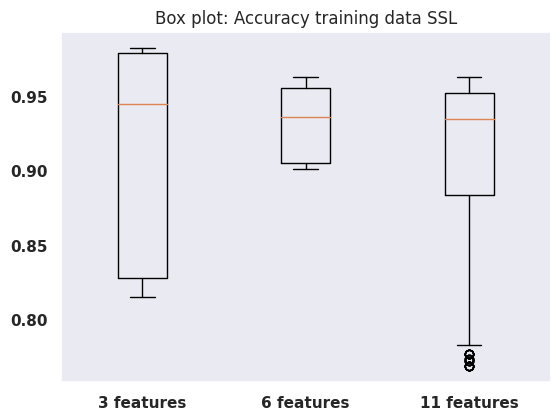

In [ ]:
# data_list
SSL_traindata_list = [results3ss[4], results6ss[4], results11ss[4]]

fig= plt.figure(figsize =(7, 5))


# Creating axes instance
ax1 = fig.add_axes([0,0, 0.7,0.7])
# x-axis labels
ax1.set_xticklabels(['3 features', '6 features',
                    '11 features'])
# Adding title
plt.title("Box plot: Accuracy training data SSL")
# Creating plot
bp = ax1.boxplot(SSL_traindata_list)
plt.grid()
# show plot


# Action
#boxplot(SSL_traindata_list)

# SSL: Error matrix training data

In [ ]:
cm3ss = confusion_matrix(results3ss[3],results3ss[2])
cm6ss = confusion_matrix(results6ss[3],results6ss[2])
cm11ss = confusion_matrix(results11ss[3],results11ss[2])

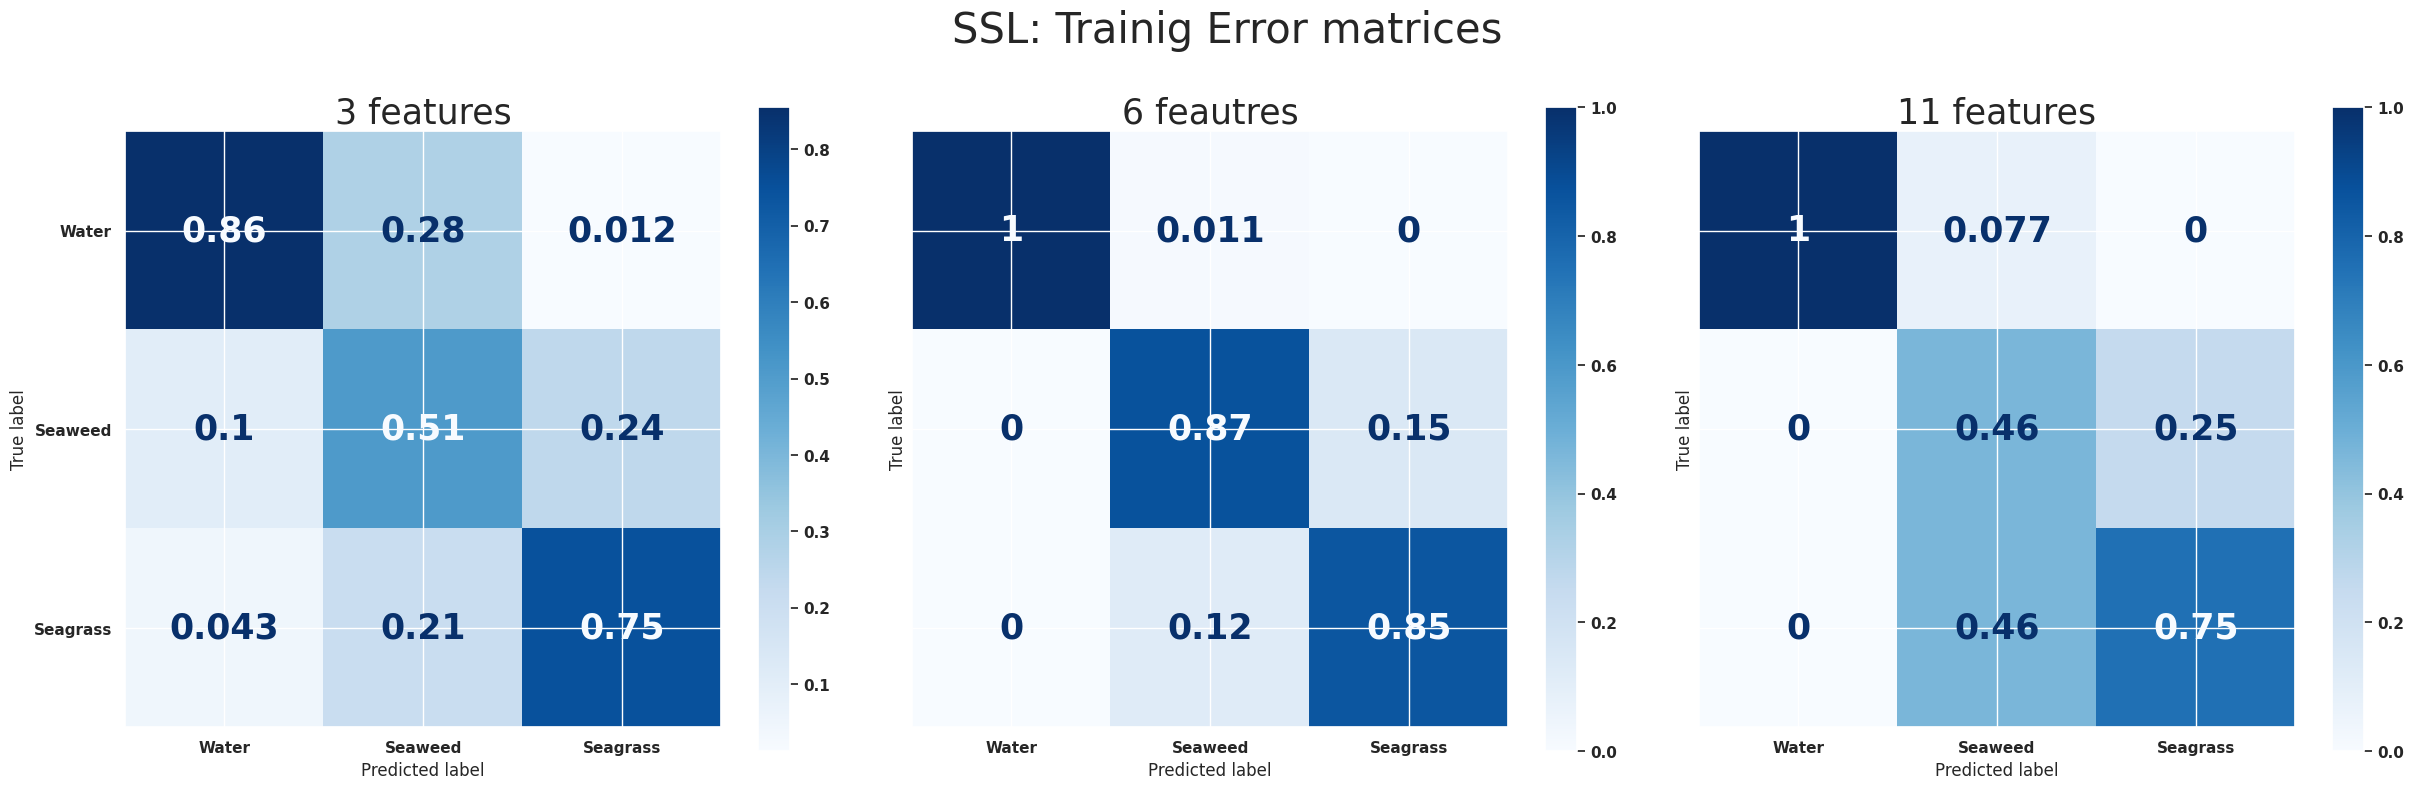

In [ ]:
# Plot confusion matrices next to each other 
# Source code: https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix. Accessed 21.03.23
font_dict = {'fontsize': 25,
            'fontweight':25}

font = {
    'weight' : 'bold',
    'size'   : 22}

fig, ax = plt.subplots(1, 3, figsize=(25,8), sharex = True, sharey = True)
fig.suptitle('SSL: Trainig Error matrices', fontsize=30)
ax[0].set_title("3 features", fontdict=font_dict)
ax[1].set_title("6 feautres", fontdict=font_dict)
ax[2].set_title("11 features", fontdict=font_dict)

metrics.ConfusionMatrixDisplay(
confusion_matrix = cm3ss/cm3ss.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[0], cmap='Blues') # values_format= '2g'

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm6ss/cm6ss.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass'] ).plot(ax=ax[1], cmap='Blues')

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm11ss/cm11ss.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[2], cmap='Blues')
#values_formatstr
plt.rc('font', **font)
plt.tight_layout()  
plt.show()

# SSL: Test data

In [ ]:
# Create a flow diagram - CLEARLY explain this process!!
def semiSupervised_test(data, data_test):

  if str(type(data.iloc[:,-1][0])) == str:
  # Convert integers into meaningfull labels
    data.iloc[:,-1].replace(['water','seaweed','seagrass'], [1,2,3], inplace=True)

  y = data.iloc[:,-1]  # Get class lables
  label = y.name       # Get the name of class label
  X = data.drop(label, axis = 1) # Get only feaures 
  #y=y.astype('int')  # y was firstly of type 'object', needs to be an integer for sklearn to recognize it.
  X_std = StandardScaler().fit_transform(X)

  # Firstly, the dataset is split into a unlabeled and a remaining datasets
  # X_unlabled is 80% of the total dataset
  X_unlabled, X_rem, y_unlabled, y_rem = train_test_split(X_std, y, train_size=0.8, random_state=42)

  # Then, the remaining data is split into a labeled and a test dataset. 
  # we have to define valid_size=0.5 (that is 50% of remaining data)
  # The labled and test datasets each conaints 10% of the samples from the total data 

  test_size = 0.5
  X_labeled, X_test, y_labeled, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42, shuffle=True)

  # Create a training and validation data from the labled data
  X_train, X_valid, y_train, y_valid = train_test_split(X_labeled, y_labeled, test_size=0.5, random_state=42, shuffle=True)


  # Initialize classifier
  rfc=RandomForestClassifier(random_state=42)
  param_grid = {'n_estimators':[int(x) for x in np.linspace(start=10, stop = 30, num = 5)],
              'max_features': ['sqrt', 'log2', None],
              'max_depth':[2,4,10],
              'min_samples_split': [2,5],
              'min_samples_leaf':[1,2],
              'bootstrap':[True, False]}

# USe cv = 10 to train on as "much" training samples as possible from the data we have
  CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv= 10, refit=True)
  CV_rfc.fit(X_train, y_train)

  preds = CV_rfc.predict(X_unlabled)

  # Merge dataset containing the labels
  # Merge dataset containing the labels
  y_pseudo = np.append(preds, y_train)

  # Merge dataset containing samples 
  pseudo_data = np.append(X_unlabled, X_train, axis=0)

  rf = RandomForestClassifier(random_state=3)

# As cv=integer (5) and y is a multiclass, stratified k-fold is used. This means that the preserves the percentage of samples of each class in each split.
# See documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html. Accesssed. 21.03.23
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold. Accesssed. 21.03.23
# Use cv = 5 to train pseudo data on, set to 5 to have bigger test-data sets to test on.
  CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv= 5, refit=True)
  CV_rf.fit(pseudo_data, y_pseudo)

  y_test2= data_test.iloc[:,-1]  # Get class lables
  label = y_test2.name       # Get the name of class label
  X_test2 = data_test.drop(label, axis = 1) # Get only feaures 
  X_std_test = StandardScaler().fit_transform(X_test2)

  preds_pseudo = CV_rf.predict(X_std_test)
  cm = confusion_matrix(preds_pseudo, y_test2)
  mean_test_score_3f = CV_rfc.cv_results_['mean_test_score']
  return accuracy_score(y_test2, preds_pseudo), len(X.columns), preds_pseudo, y_test2, mean_test_score_3f
  '''
  Returns the overall accuracy of the classifier, the number of features, and an array containing all the predicted values
  '''


In [ ]:
start3 = time.time()
results3tss = semiSupervised_test(pb3_train, pb3_test)
print(f'SSL classification with 3 features complete in: {(time.time() - start3)/60:,.2f} minutes')

start6 = time.time()
results6tss = semiSupervised_test(pb6_train, pb6_test)
print(f'SSL classification with 6 features complete in: {(time.time() - start6)/60:,.2f} minutes')

start11 = time.time()
results11tss = semiSupervised_test(obia_train, obia_test)
print(f'SSL classification with 11 features complete in: {(time.time() - start11)/60:,.2f} minutes')


SSL classification with 3 features complete in: 4.43 minutes
SSL classification with 6 features complete in: 4.84 minutes
SSL classification with 11 features complete in: 3.94 minutes


In [ ]:
print(f'{results3tss[0]*100:,.2f} where accuratly classified given 3 features and no duplicates')
print(f'{results6tss[0]*100:,.2f} where accuratly classified given 6 features and no duplicates')
print(f'{results11tss[0]*100:,.2f} where accuratly classified given 11 features and no duplicates')

50.36 where accuratly classified given 3 features and no duplicates
74.64 where accuratly classified given 6 features and no duplicates
67.62 where accuratly classified given 11 features and no duplicates


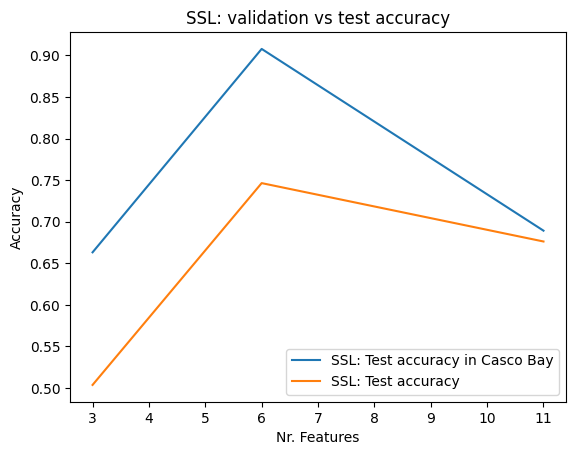

In [ ]:
# SML: Accuracy of validation and test 
x = [3, 6, 11]
y = [results3ss[0], results6ss[0], results11ss[0]]
y2 = [results3tss[0], results6tss[0], results11tss[0]]
      
plt.plot(x, y, label = "SSL: Test accuracy in Casco Bay", )
plt.plot(x, y2, label = "SSL: Test accuracy")

plt.xlabel('Nr. Features')
plt.ylabel('Accuracy')
plt.title('SSL: validation vs test accuracy')
plt.legend()
plt.show()

#SSL: Test Tau

In [ ]:
pra3ss = results3tss[0] # Overall accuracy
pra6ss = results6tss[0] # Overall accuracy
pra11ss = results11tss[0] # Overall accuracy

def tau(pra_x):
  pre = np.float64(0.33333)    #chance from three classes are 0.3333  
  tau =  (pra_x - pre)/(1-pre)
  return print(f'tau = {tau:.3f}')

print(f' SML with 3 features has:')
tau3ss = tau(pra3ss)
print(f' SML with 6 features has:')
tau6ss = tau(pra6ss)
print(f' SML with 11 features has:')
tau11ss = tau(pra11ss)

 SML with 3 features has:
tau = 0.000
 SML with 6 features has:
tau = 0.587
 SML with 11 features has:
tau = 0.463


#SSL: Error matrix test data

In [ ]:
# results3tss[2] = y_pred 
# results3tss[3] = y_true 
# cm = confusion_matrix(y_true,y_pred) 
cm3tss = confusion_matrix(results3tss[3],results3tss[2]) 
cm6tss = confusion_matrix(results6tss[3],results6tss[2])
cm11tss = confusion_matrix(results11tss[3],results11tss[2])

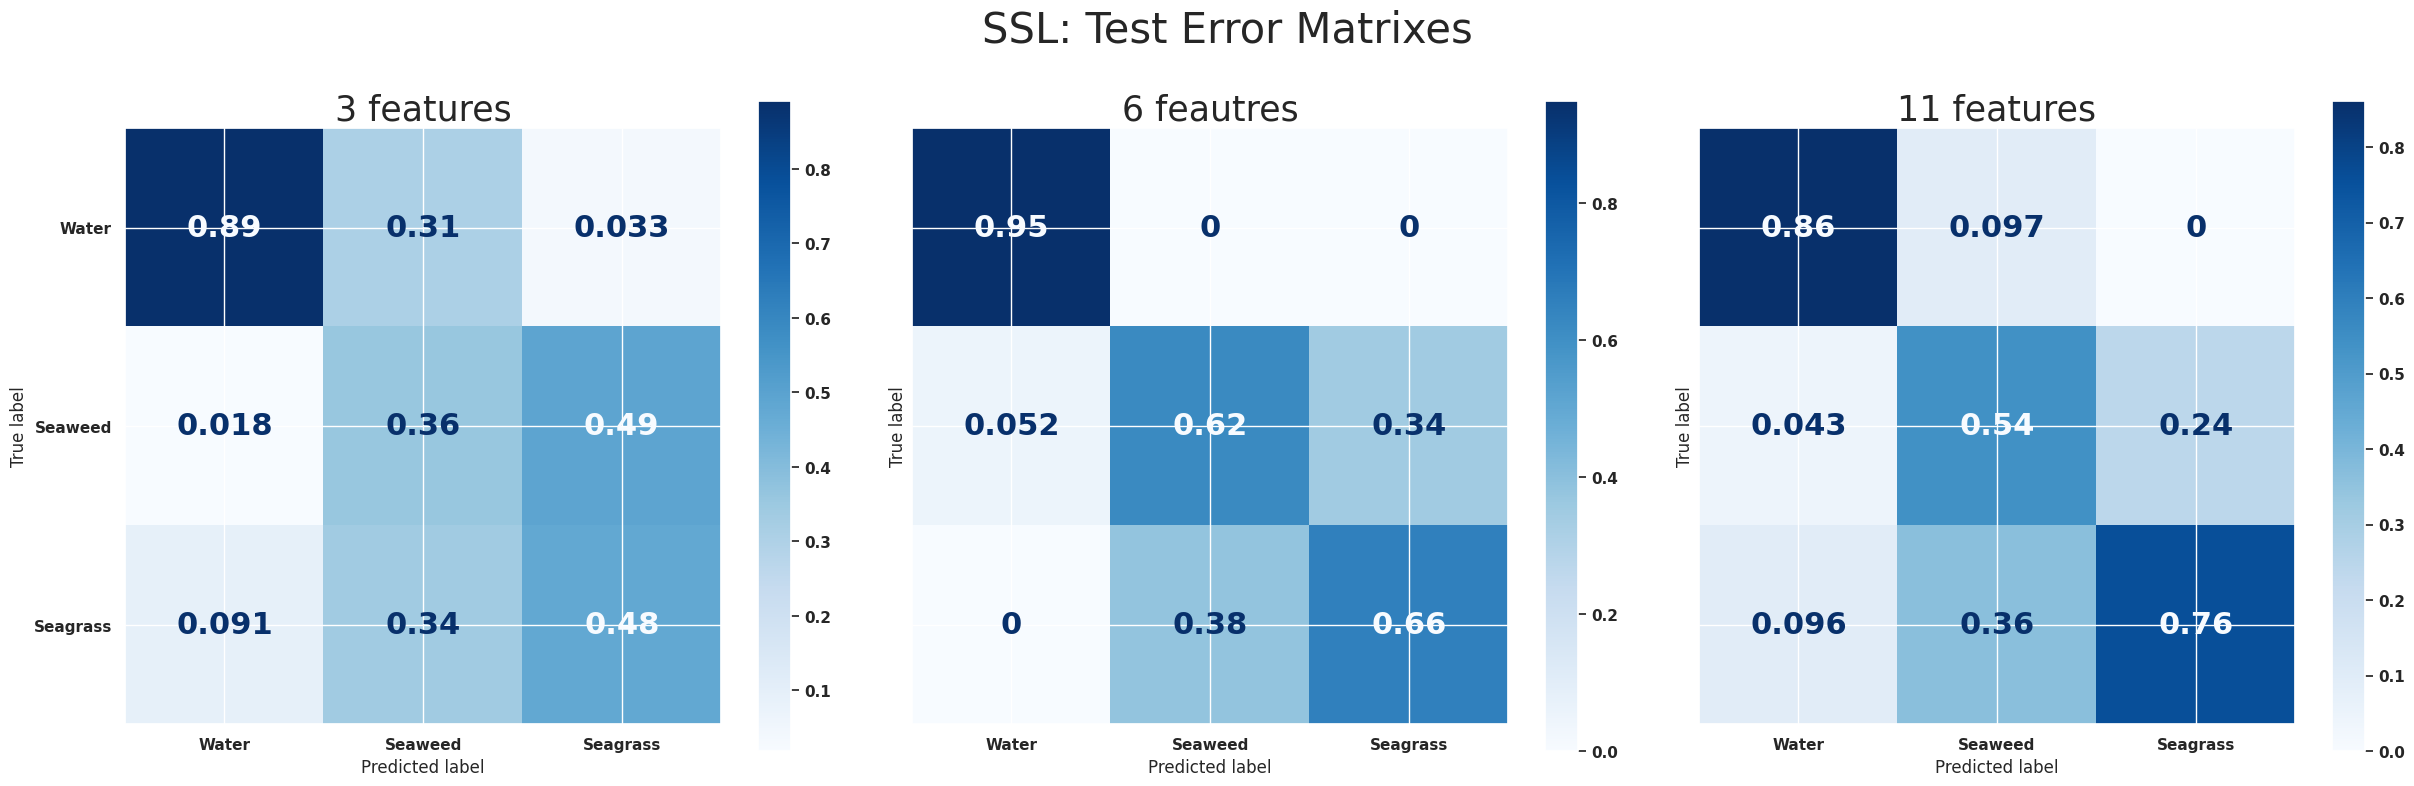

In [ ]:
# Plot confusion matrices next to each other 
# Source code: https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix. Accessed 21.03.23
font_dict = {'fontsize': 25,
            'fontweight':25}

font = {
    'weight' : 'bold',
    'size'   : 22}

fig, ax = plt.subplots(1, 3, figsize=(25,8), sharex = True, sharey = True)
fig.suptitle('SSL: Test Error Matrixes', fontsize=30)
ax[0].set_title("3 features", fontdict=font_dict)
ax[1].set_title("6 feautres", fontdict=font_dict)
ax[2].set_title("11 features", fontdict=font_dict)

metrics.ConfusionMatrixDisplay(
confusion_matrix = cm3tss/cm3tss.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[0], cmap='Blues') # values_format= '2g'

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm6tss/cm6tss.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass'] ).plot(ax=ax[1], cmap='Blues')

metrics.ConfusionMatrixDisplay(
confusion_matrix =cm11tss/cm11tss.astype(float).sum(axis=0), display_labels=['Water','Seaweed','Seagrass']).plot(ax=ax[2], cmap='Blues')
#values_formatstr
plt.rc('font', **font)
plt.tight_layout()  
plt.show()

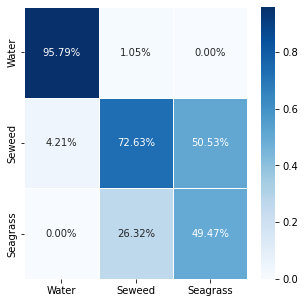

In [ ]:
conf_matrix(cm11tss)

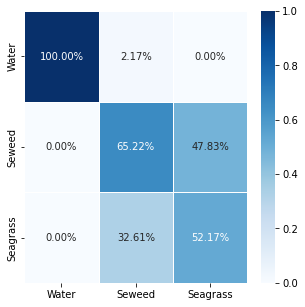

In [ ]:
conf_matrix(cm6tss)

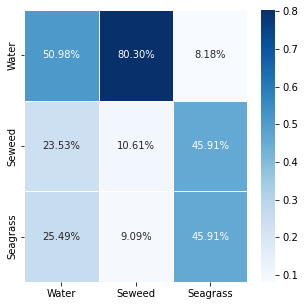

In [ ]:
conf_matrix(cm3tss)

# SSL: Tau coefficient

In [ ]:
pra3ss = results3ss[0] # Overall accuracy
pra6ss = results6ss[0] # Overall accuracy
pra11ss = results11ss[0] # Overall accuracy

def tau(pra_x):
  pre = np.float64(0.33333)    #chance from three classes are 0.3333  
  tau =  (pra_x - pre)/(1-pre)
  return print(f'tau = {tau:.3f}')

print(f' SML with 3 features has:')
tau3ss = tau(pra3ss)
print(f' SML with 6 features has:')
tau6ss = tau(pra6ss)
print(f' SML with 11 features has:')
tau11ss = tau(pra11ss)


 SML with 3 features has:
tau = 0.495
 SML with 6 features has:
tau = 0.862
 SML with 11 features has:
tau = 0.534
